In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import torch
import torchvision
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import cv2
import time


In [3]:
image_size = (512,512)

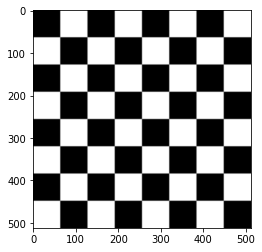

In [4]:
img_path = "/workspace/inpaint_mask/data/082243405844065.jpg"
grid_img = transforms.Resize(size= image_size)(Image.open(img_path))
grid_img = np.array(grid_img)[...,np.newaxis]
grid_img = np.repeat(grid_img,3,axis=2)
plt.imshow(grid_img)

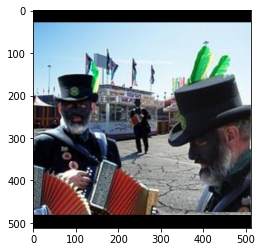

In [5]:
img_path = "/workspace/inpaint_mask/data/warpData/CIHP/Training/tps_dgrid_p16//origin//0000333.jpg"
origin_img = transforms.Resize(size= image_size)(Image.open(img_path))
img = np.array(origin_img)
plt.imshow(img)

In [ ]:
# img_path = "/workspace/inpaint_mask/data/celebAHQ/train_data/28133.jpg"
# origin_img = transforms.Resize(size= image_size)(Image.open(img_path))
# img = np.array(origin_img)
# plt.imshow(img)

# Grid Traingular Warp

In [ ]:
#. https://github.com/alyssaq/face_morpher/blob/dlib/facemorpher/warper.py
from matplotlib import path
import numpy as np
import scipy.spatial as spatial

def bilinear_interpolate(img, coords):
    """ Interpolates over every image channel
    http://en.wikipedia.org/wiki/Bilinear_interpolation
    :param img: max 3 channel image
    :param coords: 2 x _m_ array. 1st row = xcoords, 2nd row = ycoords
    :returns: array of interpolated pixels with same shape as coords
    """
    int_coords = np.int32(coords)
    x0, y0 = int_coords
    dx, dy = coords - int_coords

    # 4 Neighour pixels
    q11 = img[y0, x0]
    q21 = img[y0, x0+1]
    q12 = img[y0+1, x0]
    q22 = img[y0+1, x0+1]

    btm = q21.T * dx + q11.T * (1 - dx)
    top = q22.T * dx + q12.T * (1 - dx)
    inter_pixel = top * dy + btm * (1 - dy)

    return inter_pixel.T

def grid_coordinates(points):
    """ x,y grid coordinates within the ROI of supplied points
    :param points: points to generate grid coordinates
    :returns: array of (x, y) coordinates
    """
    xmin = np.min(points[:, 0])
    xmax = np.max(points[:, 0]) + 1
    ymin = np.min(points[:, 1])
    ymax = np.max(points[:, 1]) + 1
    return np.asarray([(x, y) for y in range(ymin, ymax)
                        for x in range(xmin, xmax)], np.uint32)

def process_warp(src_img, result_img, tri_affines, dst_points, delaunay):
    """
    Warp each triangle from the src_image only within the
    ROI of the destination image (points in dst_points).
    """
    roi_coords = grid_coordinates(dst_points)
    # indices to vertices. -1 if pixel is not in any triangle
    roi_tri_indices = delaunay.find_simplex(roi_coords)

    for simplex_index in range(len(delaunay.simplices)):
        coords = roi_coords[roi_tri_indices == simplex_index]
        num_coords = len(coords)
        out_coords = np.dot(tri_affines[simplex_index],
                            np.vstack((coords.T, np.ones(num_coords))))
        x, y = coords.T
        result_img[y, x] = bilinear_interpolate(src_img, out_coords)

    return None

def triangular_affine_matrices(vertices, src_points, dest_points):
    """
    Calculate the affine transformation matrix for each
    triangle (x,y) vertex from dest_points to src_points
    :param vertices: array of triplet indices to corners of triangle
    :param src_points: array of [x, y] points to landmarks for source image
    :param dest_points: array of [x, y] points to landmarks for destination image
    :returns: 2 x 3 affine matrix transformation for a triangle
    """
    ones = [1, 1, 1]
    for tri_indices in vertices:
        src_tri = np.vstack((src_points[tri_indices, :].T, ones))
        dst_tri = np.vstack((dest_points[tri_indices, :].T, ones))
        mat = np.dot(src_tri, np.linalg.inv(dst_tri))[:2, :]
        yield mat

def warp_image(src_img, src_points, dest_points, dest_shape, dtype=np.uint8):
    # Resultant image will not have an alpha channel
    num_chans = 3
    src_img = src_img[:, :, :3]

    rows, cols = dest_shape[:2]
    # result_img = np.zeros((rows, cols, num_chans), dtype)
    result_img = src_img.copy()

    delaunay = spatial.Delaunay(dest_points)
    tri_affines = np.asarray(list(triangular_affine_matrices(
    delaunay.simplices, src_points, dest_points)))

    process_warp(src_img, result_img, tri_affines, dest_points, delaunay)

    return result_img

def get_var_map(img,mesh):
    var_map = np.zeros((img.shape[0],img.shape[1],1))
    for x in range(mesh.shape[1]-1):
        for y in range(mesh.shape[2]-1):
            start_x,start_y = mesh[:,x,y]
            end_x,end_y = mesh[:,x+1,y+1]
            
            gird = img[start_y:end_y,start_x:end_x,:]
            grid_var = np.var(gird,keepdims=False)
            var_map[start_y:end_y,start_x:end_x,:] =  grid_var
    return var_map

def get_tri_varmap(img,mesh_pts):
    tri = spatial.Delaunay(mesh_pts)
    print(tri.simplices.shape)

    """ 製作 traingle_var_map """
    tri_varmap = np.zeros((img.shape[0],img.shape[1],1))

    x, y = np.meshgrid(np.arange(tri_varmap.shape[1]), np.arange(tri_varmap.shape[0]))
    x, y = x.flatten(), y.flatten()

    points = np.vstack((x,y)).T

    for ith in range(len(tri.simplices)):
        p = path.Path(tri.points[tri.simplices][ith])
        sample_pixel = p.contains_points(points).reshape(tri_varmap.shape[0],tri_varmap.shape[1])
        # print(" sample_pixel", sample_pixel)
        tri_area = img[sample_pixel]
        # print( tri_area.shape)
        tri_var = np.var(tri_area,keepdims=False)
        tri_varmap[sample_pixel] =  tri_var
    return tri_varmap

def mix_mask_var(mask,varmap,threshold=0.7):
    # inverse mask to only select mask area
    inv_mask = np.abs(mask - 1)
    mask_varmap = inv_mask * varmap

    # normalize
    mask_varmap = mask_varmap/mask_varmap.max()
    
    # inverse mask_varmap (is the truthly result varmap)
    # make mask_area --> 0, unmask --> 1
    # [0,1] -1 --> [-1,0] --> abs([-1,0]) --> [1,0] 
    mask_varmap = np.abs(mask_varmap -1 )
    
    if threshold == -1:
        return mask_varmap
    
    # Threshold
    # make the final mask like trimap only 0, 0.5, 1 --> mask, undefined, unmask
    # mask area, set to 0
    mask_varmap = np.where(mask_varmap<threshold,np.zeros_like(mask_varmap),mask_varmap)
    # unmask area
    # set to -1 first, to avoid become undefined area, will use abs latter to recover 
    mask_varmap = np.where(mask_varmap==1,-1 * np.ones_like(mask_varmap),mask_varmap)
    # undefined area, set to 0.5
    mask_varmap = np.where(mask_varmap>=threshold,0.5 * np.ones_like(mask_varmap),mask_varmap)
    # recover unmask area from -1 to 1
    mask_varmap = np.abs(mask_varmap)

    
    # print(mask_varmap.min(),mask_varmap.max())
    return mask_varmap

def create_grid_mask(src_img,sample_pts_mesh_xy,mesh_tran):
    # Create mask
    mask = np.ones((src_img.shape[0],src_img.shape[1],1))
    # print("mask",mask.shape)
    for x,y in sample_pts_mesh_xy:
        start_x,start_y = mesh_tran[:,x-1,y-1]
        end_x,end_y = mesh_tran[:,x+1,y+1]
        # print("fdewef",mesh_tran[:,x-1,y-1], mesh_tran[:,x,y], mesh_tran[:,x+1,y+1])
        mask[start_y:end_y,start_x:end_x] = 0
    return mask

def create_triangle_mask(src_img,sample_pts,mesh_tran_pts):
    tri = spatial.Delaunay(mesh_tran_pts)
    """ 找出 sample_pts 對應在 mesh_tran_pts 的 index """
    indexes = []
    for idx,(x,y) in enumerate(mesh_tran_pts):
        for sx,sy in sample_pts:
            if sx == x and sy == y:
                indexes.append(idx)
    # print(indexes)

    """ 找出 sample_pts 所在的三角形，理論上大概要有五個左右 """
    sample_traingle_idxs = [ [] for i in range(len(indexes))]
    for idx in range(len(tri.simplices)):
        i1,i2,i3 = tri.simplices[idx]
        for target_idx in range(len(indexes)):
            target = indexes[target_idx]
            if i1 == target or target == i2 or target == i3:
                sample_traingle_idxs[target_idx].append(idx)

    """ 將所有 sample_pts 所在的三角形 搜集起來 """            
    sample_triangles=[]
    for idx in range(len(sample_traingle_idxs)):
        sample_triangles.append( tri.points[tri.simplices[sample_traingle_idxs[idx]]])
        # print(tri.points[tri.simplices[sample_traingle_idxs[idx]]].shape)
    sample_triangles= np.vstack(sample_triangles)

    """ 製作 traingle_mask """
    mask_sample = np.ones((src_img.shape[0],src_img.shape[1],1))

    x, y = np.meshgrid(np.arange(mask_sample.shape[1]), np.arange(mask_sample.shape[0]))
    x, y = x.flatten(), y.flatten()

    points = np.vstack((x,y)).T

    for ith in range(len(sample_triangles)):
        p = path.Path(sample_triangles[ith])
        grid = p.contains_points(points).reshape(mask_sample.shape[0],mask_sample.shape[1],1)
        mask_sample[grid] = 0
    
    return mask_sample


class GridTriangularWarp:
    
    def __init__(self, mesh_size = 18 ,num_vertex_wanted_to_move=10, warp_min_factor=1,warp_max_factor=9,return_mesh=True, debug = False ):
        self.mesh_size = mesh_size
        self.num_vertex_wanted_to_move = num_vertex_wanted_to_move
        self.warp_min_factor = warp_min_factor
        self.warp_max_factor = warp_max_factor
        self.return_mesh = return_mesh
        
        self.debug = debug
        
    def __call__(self, pillow_img):
        src_img = np.array(pillow_img)
        image_size = (src_img.shape[0],src_img.shape[1])

        # Create Mesh
        x = np.linspace(2,  image_size[0]-2, image_size[0]//self.mesh_size)
        y = np.linspace(2,  image_size[1]-2, image_size[1]//self.mesh_size)
        # x = np.linspace(self.mesh_size,  image_size[0]-self.mesh_size, image_size[0]//self.mesh_size)
        # y = np.linspace(self.mesh_size,  image_size[1]-self.mesh_size, image_size[1]//self.mesh_size)
        xv, yv = np.meshgrid( y,x)
        mesh = np.concatenate( (xv[np.newaxis,:], yv[np.newaxis,:]) )
        mesh = np.int32(mesh)
        mesh_pts = mesh.reshape(2,-1).T
    
        
        # Create Deform Mesh
        # print("mesh",mesh.shape)
        sample_pts_mesh_xy = np.concatenate(
            (
                np.random.randint( 1,mesh.shape[1]-2, size=(self.num_vertex_wanted_to_move, 1)),
                np.random.randint( 1,mesh.shape[2]-2, size=(self.num_vertex_wanted_to_move, 1))
            ),axis=1
        )
        

        # print("sample_pts_mesh_xy",sample_pts_mesh_xy.shape) 
        mesh_tran = mesh.copy()
        sample_pts = []
        for x, y in sample_pts_mesh_xy:     
            effect = 0.1 * np.random.randint(self.warp_min_factor,self.warp_max_factor,size = 2)
            sign = 2 * np.random.randint(2,size = 2) -1 
            shift_vector = np.ones(2)
            shift_vector[0] *=  self.mesh_size * effect[0] * sign[0]
            shift_vector[1] *=  self.mesh_size * effect[1] * sign[1]
            # print(image_size[1]//self.mesh_size)
            # print(shift_vector,np.int32(shift_vector))
            mesh_tran[:,x,y] += np.int32(shift_vector)
            sample_pts.append(mesh_tran[:,x,y])
        sample_pts = np.stack(sample_pts)
        sample_pts = np.array(sample_pts, dtype=np.int32)
        
        mesh_tran = np.array(mesh_tran, dtype= np.int32)
        mesh_tran_pts =mesh_tran.reshape(2,-1).T
      
        
        mesh_pts = np.array(mesh_pts,dtype=np.int32)
        mesh_tran_pts = np.array(mesh_tran_pts,dtype= np.int32)
        result_img = warp_image(src_img ,mesh_pts, mesh_tran_pts, image_size )
        warpped_img = Image.fromarray(np.clip(result_img, 0.0, 255.0).astype(np.uint8))
              
        if self.return_mesh:
            
            """ createGTmask -------------------------------------------- """
            # Create mask
            mask = create_grid_mask(src_img,sample_pts_mesh_xy,mesh_tran)
            # tri_mask = mask
            tri_mask = create_triangle_mask(src_img,sample_pts,mesh_tran_pts)
            
            # Create var map
            var_map = get_var_map(src_img,mesh)
            warpped_var_map = warp_image(var_map ,mesh_pts, mesh_tran_pts, image_size )
            
            # Create tri varmap
            tri_varmap = get_tri_varmap(src_img,mesh_pts)
            warpped_tri_varmap = warp_image(tri_varmap ,mesh_pts, mesh_tran_pts, image_size )
            
            # Var(Warp(Origin)
            var_map_use = get_var_map(np.array(warpped_img),mesh)
            mask_var_map = mix_mask_var(mask,var_map_use,threshold=-1)
            
            tri_varmap_use =  get_tri_varmap(np.array(warpped_img),mesh_pts)
            tri_mask_varmap =  mix_mask_var(tri_mask,tri_varmap_use,threshold=-1)
            """ ---------------------------------------------------------- """
            if self.debug:
                
                return warpped_img,mesh_pts,mesh_tran_pts, mask,sample_pts, mesh,mesh_tran,var_map,warpped_var_map, mask_var_map, sample_pts_mesh_xy,tri_mask,tri_varmap,warpped_tri_varmap, tri_mask_varmap
            else:
                return warpped_img,mesh_pts,mesh_tran_pts, mask
        
        return warpped_img
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"


In [ ]:
def plot_mesh_grid(mesh):
    x,y = mesh
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    plt.gca().add_collection(LineCollection(segs1,color="white"))
    plt.gca().add_collection(LineCollection(segs2,color="white"))

In [ ]:
warp_f = GridTriangularWarp(mesh_size = 18 ,num_vertex_wanted_to_move=10, warp_min_factor=1,warp_max_factor=9,return_mesh=True, debug = True )

In [ ]:
warpped_img,mesh_pts,mesh_tran_pts, mask,sample_pts, mesh,mesh_tran,var_map,warpped_var_map, mask_var_map, sample_pts_mesh_xy,tri_mask,tri_varmap,warpped_tri_varmap, tri_mask_varmap= warp_f(origin_img)

In [ ]:
def create_guassian_blur_f(guassian_ksize,guassian_sigma):
    return lambda x: cv2.GaussianBlur(x, (guassian_ksize, guassian_ksize), guassian_sigma)[...,np.newaxis]

ifzeroksize = lambda sigma: round(sigma*3*2 + 1) | 1

In [ ]:
guassian_blur_f = create_guassian_blur_f(17,0.0)
blur = guassian_blur_f(tri_mask)
plt.imshow(blur,vmin=0,vmax=1,cmap = "gray")

In [ ]:
# ksize  5,13,7
will_blur_img = tri_mask_varmap
fig, axs = plt.subplots(2, 4, figsize=(16,8))
axs[0,0].set_title('origin')
axs[0,0].imshow(will_blur_img,vmin=0,vmax=1,cmap = "gray")
axs[1,0].imshow( Image.fromarray(np.uint8(np.array(warpped_img) *  will_blur_img) ) )


axs[0,1].set_title('ksize: 9')
blurred = create_guassian_blur_f(5,0.0)(will_blur_img)
axs[0,1].imshow( blurred  ,vmin=0,vmax=1,cmap = "gray")
axs[1,1].imshow( Image.fromarray(np.uint8(np.array(warpped_img) *  blurred) ) )


axs[0,2].set_title('ksize: 13')
blurred = create_guassian_blur_f(13,0.0)(will_blur_img)
axs[0,2].imshow( blurred  ,vmin=0,vmax=1,cmap = "gray")
axs[1,2].imshow( Image.fromarray(np.uint8(np.array(warpped_img) *  blurred) ) )

axs[0,3].set_title('ksize: 17')
blurred = create_guassian_blur_f(17,0.0)(will_blur_img)
axs[0,3].imshow( blurred  ,vmin=0,vmax=1,cmap = "gray")
axs[1,3].imshow( Image.fromarray(np.uint8(np.array(warpped_img) *  blurred) ) )


In [ ]:
# sigma  0.0, 3.0, 7.0
will_blur_img = tri_mask_varmap
fig, axs = plt.subplots(2, 4, figsize=(16,8))
axs[0,0].set_title('origin')
axs[0,0].imshow(will_blur_img,vmin=0,vmax=1,cmap = "gray")
axs[1,0].imshow( Image.fromarray(np.uint8(np.array(warpped_img) *  will_blur_img) ) )


axs[0,1].set_title('sigma: 0.0')
blurred = create_guassian_blur_f(13,0.0)(will_blur_img)
axs[0,1].imshow( blurred  ,vmin=0,vmax=1,cmap = "gray")
axs[1,1].imshow( Image.fromarray(np.uint8(np.array(warpped_img) *  blurred) ) )

axs[0,2].set_title('sigma: 3.0')
blurred = create_guassian_blur_f(13,3.0)(will_blur_img)
axs[0,2].imshow( blurred  ,vmin=0,vmax=1,cmap = "gray")
axs[1,2].imshow( Image.fromarray(np.uint8(np.array(warpped_img) *  blurred) ) )

axs[0,3].set_title('sigma: 7.0')
blurred = create_guassian_blur_f(13,7.0)(will_blur_img)
axs[0,3].imshow( blurred  ,vmin=0,vmax=1,cmap = "gray")
axs[1,3].imshow( Image.fromarray(np.uint8(np.array(warpped_img) *  blurred) ) )


In [ ]:
Image.fromarray(np.uint8(np.array(warpped_img) * create_guassian_blur_f(13,7.0)(will_blur_img)))

In [ ]:
""" tri varmap with tri mask """
fig, axs = plt.subplots(1, 4, figsize=(16,8))
axs[0].imshow(tri_mask,vmin=0,vmax=1,cmap = "gray")
axs[1].imshow(tri_varmap,vmin=0,vmax=1,cmap = "gray")
axs[2].imshow(warpped_tri_varmap)
im = axs[3].imshow(tri_mask_varmap,vmin=0,vmax=1,cmap = "gray")
cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')

In [ ]:
""" Traingluar mask """
fig, axs = plt.subplots(2, 3, figsize=(16,16))
axs[0,0].imshow(tri_mask,vmin=0,vmax=1,cmap="gray")
axs[0,1].imshow(mask,vmin=0,vmax=1 ,cmap="gray")
axs[0,2].imshow(tri_mask + mask,vmin=0,vmax=1 ,cmap="gray")
axs[0,2].plot(sample_pts[:,0],sample_pts[:,1],'o',color="red")
axs[1,0].imshow( Image.fromarray(np.uint8(np.array(warpped_img) * tri_mask)))
axs[1,1].imshow( Image.fromarray(np.uint8(np.array(warpped_img) * mask)))
axs[1,2].imshow(warpped_img)
target_pts = mesh_tran_pts
axs[1,2].imshow(tri_mask + mask,vmin=0,vmax=1 ,cmap="gray")
axs[1,2].plot(target_pts[:,0], target_pts[:,1], 'o')
axs[1,2].plot(sample_pts[:,0],sample_pts[:,1],'o',color="red")
axs[1,2].triplot(target_pts[:,0], target_pts[:,1], spatial.Delaunay(target_pts).simplices.copy())
plt.show()

In [ ]:
""" Warp check """

src_pts = mesh_pts
target_pts = mesh_tran_pts

fig, axs = plt.subplots(1, 4, figsize=(32,8))
axs[0].imshow(origin_img)

axs[1].imshow(warpped_img)

axs[2].imshow(origin_img)
axs[2].plot(src_pts[:,0], src_pts[:,1], 'o')
axs[2].triplot(src_pts[:,0], src_pts[:,1], spatial.Delaunay(src_pts).simplices.copy())

axs[3].imshow(warpped_img)
axs[3].plot(target_pts[:,0], target_pts[:,1], 'o')
axs[3].plot(sample_pts[:,0],sample_pts[:,1],'o',color="red")
axs[3].triplot(target_pts[:,0], target_pts[:,1], spatial.Delaunay(target_pts).simplices.copy())

print("warp different:", np.abs(np.array(origin_img) - np.array(warpped_img)).mean())

In [ ]:
""" Identity warp check """
identiy_warp = warp_image(np.array(origin_img) ,mesh_pts, mesh_pts , image_size )
identiy_warp = Image.fromarray(np.clip(identiy_warp, 0.0, 255.0).astype(np.uint8))
fig, axs = plt.subplots(1, 2, figsize=(8,8))
axs[0].imshow(origin_img)
axs[1].imshow(identiy_warp)
print("identity warp different:", np.abs(np.array(origin_img) - np.array(identiy_warp)).mean())

In [ ]:
# Guassion Kernel
# x, y = np.mgrid[-1:2, -1:2]
# gaussian_kernel = np.exp(-(x**2+y**2))
# gaussian_kernel = gaussian_kernel / gaussian_kernel.sum()
# from scipy import signal
# # mask_varmap_conved = signal.convolve2d(mask_varmap[:,:,0], gaussian_kernel, boundary='symm', mode='same') #卷積
# # plt.imshow(mask_varmap_conved)
# # plt.colorbar()


In [ ]:
""" tri_mask_varmap check (Var(Warp(Origin)) """
var_map_use = get_tri_varmap(np.array(warpped_img),mesh_pts)
mask_varmap = mix_mask_var(tri_mask,
                           var_map_use,
                           threshold=-1)

fig, axs = plt.subplots(1, 2, figsize=(8,8))
im1 =axs[0].imshow(var_map_use/var_map_use.max())
im2 = axs[1].imshow(mask_varmap,cmap="gray")
# cax1 = fig.add_axes([0.27, 0.8, 0.5, 0.05])
# cax2 = fig.add_axes([0.27, 0.7, 0.5, 0.05])
# fig.colorbar(im1, cax=cax1, orientation='horizontal')
# fig.colorbar(im2, cax=cax2, orientation='horizontal')
plt.show()

# -----------

masked_warp = np.uint8(np.array(warpped_img)*mask_varmap)
masked_origin = np.uint8(np.array(origin_img)*mask_varmap)
fig, axs = plt.subplots(1, 4, figsize=(16,8))
axs[0].set_title('mask_varmap on orign')
axs[0].imshow(masked_origin)

axs[1].set_title('mask_varmap on warpped')
axs[1].imshow(masked_warp)


diff = np.abs(masked_origin - masked_warp)
# print(masked_origin.max(),masked_warp.max())
print("[masked]    ",diff.mean(),"diff.max():",diff.max())
print("[not masked]", np.abs(np.array(origin_img) - np.array(warpped_img)).mean())
tmp = np.ones_like( np.array(origin_img)) * 0
tmp[np.where(diff != 0)] - 0
axs[2].set_title('Difference')
axs[2].imshow(diff*255)

masked_img = Image.fromarray(np.uint8(np.array(warpped_img) * mask_varmap))
axs[3].set_title('Mask with mesh')
axs[3].imshow(mask_varmap ,cmap="gray")
axs[3].plot(mesh_tran_pts[:,0], mesh_tran_pts[:,1], 'o')
axs[3].plot(sample_pts[:,0],sample_pts[:,1],'o',color="red")
axs[3].triplot(mesh_tran_pts[:,0], mesh_tran_pts[:,1], spatial.Delaunay(mesh_tran_pts).simplices.copy())
plt.show()

In [ ]:
""" mask_varmap check (Warp(Var(Origin)) """
var_map_use = warpped_tri_varmap
mask_varmap = mix_mask_var(tri_mask,
                           var_map_use,
                           threshold=0.7)


fig, axs = plt.subplots(1, 2, figsize=(8,8))
axs[0].imshow(var_map_use)
axs[1].imshow(mask_varmap,cmap="gray")
plt.show()

masked_warp = np.uint8(np.array(warpped_img)*mask_varmap)
masked_origin = np.uint8(np.array(origin_img)*mask_varmap)
fig, axs = plt.subplots(1, 4, figsize=(16,8))
axs[0].set_title('mask_varmap on orign')
axs[0].imshow(masked_origin)

axs[1].set_title('mask_varmap on warpped')
axs[1].imshow(masked_warp)


diff = np.abs(masked_origin - masked_warp)
# print(masked_origin.max(),masked_warp.max())
print("[masked]    ",diff.mean(),"diff.max():",diff.max())
print("[not masked]", np.abs(np.array(origin_img) - np.array(warpped_img)).mean())
tmp = np.ones_like( np.array(origin_img)) * 0
tmp[np.where(diff != 0)] - 0
axs[2].set_title('Difference')
axs[2].imshow(diff*255)

masked_img = Image.fromarray(np.uint8(np.array(warpped_img) * mask_varmap))
axs[3].set_title('Mask with mesh')
axs[3].imshow(mask_varmap ,cmap="gray")
axs[3].plot(mesh_tran_pts[:,0], mesh_tran_pts[:,1], 'o')
axs[3].plot(sample_pts[:,0],sample_pts[:,1],'o',color="red")
axs[3].triplot(mesh_tran_pts[:,0], mesh_tran_pts[:,1], spatial.Delaunay(mesh_tran_pts).simplices.copy())
plt.show()

In [ ]:
""" mask_varmap check (Var(Warp(Origin)) """
var_map_use = get_var_map(np.array(warpped_img),mesh)
mask_varmap = mix_mask_var(mask,
                           var_map_use,
                           threshold=0.7)

fig, axs = plt.subplots(1, 2, figsize=(8,8))
im1 =axs[0].imshow(var_map_use/var_map_use.max())
im2 = axs[1].imshow(mask_varmap,cmap="gray")
# cax1 = fig.add_axes([0.27, 0.8, 0.5, 0.05])
# cax2 = fig.add_axes([0.27, 0.7, 0.5, 0.05])
# fig.colorbar(im1, cax=cax1, orientation='horizontal')
# fig.colorbar(im2, cax=cax2, orientation='horizontal')
plt.show()

# -----------

masked_warp = np.uint8(np.array(warpped_img)*mask_varmap)
masked_origin = np.uint8(np.array(origin_img)*mask_varmap)
fig, axs = plt.subplots(1, 4, figsize=(16,8))
axs[0].set_title('mask_varmap on orign')
axs[0].imshow(masked_origin)

axs[1].set_title('mask_varmap on warpped')
axs[1].imshow(masked_warp)


diff = np.abs(masked_origin - masked_warp)
# print(masked_origin.max(),masked_warp.max())
print("[masked]    ",diff.mean(),"diff.max():",diff.max())
print("[not masked]", np.abs(np.array(origin_img) - np.array(warpped_img)).mean())
tmp = np.ones_like( np.array(origin_img)) * 0
tmp[np.where(diff != 0)] - 0
axs[2].set_title('Difference')
axs[2].imshow(diff*255)

masked_img = Image.fromarray(np.uint8(np.array(warpped_img) * mask_varmap))
axs[3].set_title('Mask with mesh')
axs[3].imshow(mask_varmap ,cmap="gray")
axs[3].plot(mesh_tran_pts[:,0], mesh_tran_pts[:,1], 'o')
axs[3].plot(sample_pts[:,0],sample_pts[:,1],'o',color="red")
axs[3].triplot(mesh_tran_pts[:,0], mesh_tran_pts[:,1], spatial.Delaunay(mesh_tran_pts).simplices.copy())
plt.show()

In [ ]:
""" mask_varmap check (Warp(Var(Origin)) """
var_map_use = warpped_var_map
mask_varmap = mix_mask_var(mask,
                           var_map_use,
                           threshold=0.7)


fig, axs = plt.subplots(1, 2, figsize=(8,8))
axs[0].imshow(var_map_use)
axs[1].imshow(mask_varmap,cmap="gray")
plt.show()

masked_warp = np.uint8(np.array(warpped_img)*mask_varmap)
masked_origin = np.uint8(np.array(origin_img)*mask_varmap)
fig, axs = plt.subplots(1, 4, figsize=(16,8))
axs[0].set_title('mask_varmap on orign')
axs[0].imshow(masked_origin)

axs[1].set_title('mask_varmap on warpped')
axs[1].imshow(masked_warp)


diff = np.abs(masked_origin - masked_warp)
# print(masked_origin.max(),masked_warp.max())
print("[masked]    ",diff.mean(),"diff.max():",diff.max())
print("[not masked]", np.abs(np.array(origin_img) - np.array(warpped_img)).mean())
tmp = np.ones_like( np.array(origin_img)) * 0
tmp[np.where(diff != 0)] - 0
axs[2].set_title('Difference')
axs[2].imshow(diff*255)

masked_img = Image.fromarray(np.uint8(np.array(warpped_img) * mask_varmap))
axs[3].set_title('Mask with mesh')
axs[3].imshow(mask_varmap ,cmap="gray")
axs[3].plot(mesh_tran_pts[:,0], mesh_tran_pts[:,1], 'o')
axs[3].plot(sample_pts[:,0],sample_pts[:,1],'o',color="red")
axs[3].triplot(mesh_tran_pts[:,0], mesh_tran_pts[:,1], spatial.Delaunay(mesh_tran_pts).simplices.copy())
plt.show()

In [ ]:
""" GT Grid Mask check """
masked_warp = np.uint8(np.array(warpped_img)*mask)
masked_origin = np.uint8(np.array(origin_img)*mask)
fig, axs = plt.subplots(1, 4, figsize=(16,8))
axs[0].set_title('GTMask on oriign')
axs[0].imshow(masked_origin)

axs[1].set_title('GTMask on warpped')
axs[1].imshow(masked_warp)


diff = np.abs(masked_origin - masked_warp)
# print(masked_origin.max(),masked_warp.max())
print("[masked]    ",diff.mean(),"diff.max():",diff.max())
print("[not masked]", np.abs(np.array(origin_img) - np.array(warpped_img)).mean())
tmp = np.ones_like( np.array(origin_img)) * 0
tmp[np.where(diff != 0)] - 0
axs[2].set_title('Difference')
axs[2].imshow(diff*255)

masked_img = Image.fromarray(np.uint8(np.array(warpped_img) * mask))
axs[3].set_title('Mask with mesh')
axs[3].imshow(mask ,cmap="gray")
axs[3].plot(mesh_tran_pts[:,0], mesh_tran_pts[:,1], 'o')
axs[3].plot(sample_pts[:,0],sample_pts[:,1],'o',color="red")
axs[3].triplot(mesh_tran_pts[:,0], mesh_tran_pts[:,1], spatial.Delaunay(mesh_tran_pts).simplices.copy())
plt.show()

In [ ]:
""" GT TriMask check """
masked_warp = np.uint8(np.array(warpped_img)*tri_mask)
masked_origin = np.uint8(np.array(origin_img)*tri_mask)
fig, axs = plt.subplots(1, 4, figsize=(16,8))
axs[0].set_title('GTMask on oriign')
axs[0].imshow(masked_origin)

axs[1].set_title('GTMask on warpped')
axs[1].imshow(masked_warp)


diff = np.abs(masked_origin - masked_warp)
# print(masked_origin.max(),masked_warp.max())
print("[masked]    ",diff.mean(),"diff.max():",diff.max())
print("[not masked]", np.abs(np.array(origin_img) - np.array(warpped_img)).mean())
tmp = np.ones_like( np.array(origin_img)) * 0
tmp[np.where(diff != 0)] - 0
axs[2].set_title('Difference')
axs[2].imshow(diff*255)

masked_img = Image.fromarray(np.uint8(np.array(warpped_img) * tri_mask))
axs[3].set_title('Mask with mesh')
axs[3].imshow(tri_mask ,cmap="gray")
axs[3].plot(mesh_tran_pts[:,0], mesh_tran_pts[:,1], 'o')
axs[3].plot(sample_pts[:,0],sample_pts[:,1],'o',color="red")
axs[3].triplot(mesh_tran_pts[:,0], mesh_tran_pts[:,1], spatial.Delaunay(mesh_tran_pts).simplices.copy())
plt.show()

In [ ]:
""" varmap with mask """
fig, axs = plt.subplots(1, 4, figsize=(16,8))
axs[0].imshow(mask,cmap = "gray")
axs[1].imshow(var_map)
axs[2].imshow(warpped_var_map)
im = axs[3].imshow(mask_varmap,cmap = "gray")
cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')

In [ ]:
# """ traingular mask """ 
# spatial.Delaunay(target_pts).simplices


In [ ]:
""" varaince map check """


fig, axs = plt.subplots(2, 3, figsize=(12,8))
axs[0,0].set_title('Varmap(origin)')
axs[0,0].imshow(var_map)

axs[0,1].set_title('Warp(Varmap(origin))')
axs[0,1].imshow(warpped_var_map)


axs[0,2].set_title('Varmap(Warp(origin))')
axs[0,2].imshow(get_var_map(np.array(warpped_img),mesh))

axs[1,0].set_title('origin')
axs[1,0].imshow(origin_img)

axs[1,1].set_title('Warp(origin)')
axs[1,1].imshow(warpped_img)
axs[1,2].imshow(warpped_img)

# var_map = get_var_map(np.array(origin_img),mesh)
# plt.imshow(var_map)
# plot_mesh_grid(mesh)
# plt.colorbar()
# ----------------
# var_warpped_img = warp_image(var_map ,mesh_pts, mesh_tran_pts, image_size )
# plt.imshow(var_warpped_img)
# plt.colorbar()

# Face alignment + Trangular Warp

In [ ]:
# ! pip install face_alignment

In [ ]:
import face_alignment
from skimage import io
#. https://github.com/alyssaq/face_morpher/blob/dlib/facemorpher/warper.py
import numpy as np
import scipy.spatial as spatial

def bilinear_interpolate(img, coords):
    """ Interpolates over every image channel
    http://en.wikipedia.org/wiki/Bilinear_interpolation
    :param img: max 3 channel image
    :param coords: 2 x _m_ array. 1st row = xcoords, 2nd row = ycoords
    :returns: array of interpolated pixels with same shape as coords
    """
    int_coords = np.int32(coords)
    x0, y0 = int_coords
    dx, dy = coords - int_coords

    # 4 Neighour pixels
    q11 = img[y0, x0]
    q21 = img[y0, x0+1]
    q12 = img[y0+1, x0]
    q22 = img[y0+1, x0+1]

    btm = q21.T * dx + q11.T * (1 - dx)
    top = q22.T * dx + q12.T * (1 - dx)
    inter_pixel = top * dy + btm * (1 - dy)

    return inter_pixel.T

def grid_coordinates(points):
    """ x,y grid coordinates within the ROI of supplied points
    :param points: points to generate grid coordinates
    :returns: array of (x, y) coordinates
    """
    xmin = np.min(points[:, 0])
    xmax = np.max(points[:, 0]) + 1
    ymin = np.min(points[:, 1])
    ymax = np.max(points[:, 1]) + 1
    return np.asarray([(x, y) for y in range(ymin, ymax)
                        for x in range(xmin, xmax)], np.uint32)

def process_warp(src_img, result_img, tri_affines, dst_points, delaunay):
    """
    Warp each triangle from the src_image only within the
    ROI of the destination image (points in dst_points).
    """
    roi_coords = grid_coordinates(dst_points)
    # indices to vertices. -1 if pixel is not in any triangle
    roi_tri_indices = delaunay.find_simplex(roi_coords)

    for simplex_index in range(len(delaunay.simplices)):
        coords = roi_coords[roi_tri_indices == simplex_index]
        num_coords = len(coords)
        out_coords = np.dot(tri_affines[simplex_index],
                            np.vstack((coords.T, np.ones(num_coords))))
        x, y = coords.T
        result_img[y, x] = bilinear_interpolate(src_img, out_coords)

    return None

def triangular_affine_matrices(vertices, src_points, dest_points):
    """
    Calculate the affine transformation matrix for each
    triangle (x,y) vertex from dest_points to src_points
    :param vertices: array of triplet indices to corners of triangle
    :param src_points: array of [x, y] points to landmarks for source image
    :param dest_points: array of [x, y] points to landmarks for destination image
    :returns: 2 x 3 affine matrix transformation for a triangle
    """
    ones = [1, 1, 1]
    for tri_indices in vertices:
        src_tri = np.vstack((src_points[tri_indices, :].T, ones))
        dst_tri = np.vstack((dest_points[tri_indices, :].T, ones))
        mat = np.dot(src_tri, np.linalg.inv(dst_tri))[:2, :]
        yield mat

def warp_image(src_img, src_points, dest_points, dest_shape, dtype=np.uint8):
    # Resultant image will not have an alpha channel
    num_chans = 3
    src_img = src_img[:, :, :3]

    rows, cols = dest_shape[:2]
    # result_img = np.zeros((rows, cols, num_chans), dtype)
    result_img = src_img.copy()

    delaunay = spatial.Delaunay(dest_points)
    tri_affines = np.asarray(list(triangular_affine_matrices(
    delaunay.simplices, src_points, dest_points)))

    process_warp(src_img, result_img, tri_affines, dest_points, delaunay)

    return result_img
class FaceAlignWarp:
    
    def __init__(self, num_vertex_wanted_to_move=5, warp_min_factor=5,warp_max_factor=8 ):
        self.face_alignment = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False)
        self.num_vertex_wanted_to_move = num_vertex_wanted_to_move
        self.warp_min_factor = warp_min_factor
        self.warp_max_factor = warp_max_factor
        
    def __call__(self, pillow_img):
        src_img = np.array(pillow_img)
        src_points = self.face_alignment.get_landmarks(src_img)[0] 
        corner_pts = np.array([[0,0],[src_img.shape[0]-2,0],[src_img.shape[0]-2,src_img.shape[1]-2],[0,src_img.shape[1]-2]])
        

        result_points = src_points.copy()
        vertex_want_to_move_list = np.random.randint(0,result_points.shape[0]-1,size = self.num_vertex_wanted_to_move)
        for v in vertex_want_to_move_list:
            result_points[v] = result_points[v] + np.random.randint(self.warp_min_factor,self.warp_max_factor )
        result_points =  np.int32(result_points)
        
        src_pt_with_corner =  np.vstack((src_points,corner_pts))
        result_pt_with_corner =  np.vstack((result_points,corner_pts))
        result_img = warp_image(src_img, src_pt_with_corner, result_pt_with_corner, image_size )
        warpped_img = Image.fromarray(result_img)
        
        return warpped_img
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"


In [ ]:
warp_f = FaceAlignWarp()

In [ ]:
warp_f(origin_img)

In [ ]:
corner_pts

In [ ]:
src_points.shape

In [ ]:
plt.imshow(src_img)
plt.scatter(src_points[:,0], src_points[:,1], 2)

In [ ]:
num_vertex_want_to_move = 5
warp_min = 5
warp_max = 8

result_points = src_points.copy()
vertex_want_to_move_list = np.random.randint(0,result_points.shape[0]-1,size = num_vertex_want_to_move)
for v in vertex_want_to_move_list:
    result_points[v] = result_points[v] + np.random.randint(warp_min,warp_max )
result_points =  np.int32(result_points)

In [ ]:
result_points.shape

In [ ]:
plt.imshow(src_img)
plt.scatter(result_points[:,0], result_points[:,1], 2)

In [ ]:
#. https://github.com/alyssaq/face_morpher/blob/dlib/facemorpher/warper.py
import numpy as np
import scipy.spatial as spatial

def bilinear_interpolate(img, coords):
    """ Interpolates over every image channel
    http://en.wikipedia.org/wiki/Bilinear_interpolation
    :param img: max 3 channel image
    :param coords: 2 x _m_ array. 1st row = xcoords, 2nd row = ycoords
    :returns: array of interpolated pixels with same shape as coords
    """
    int_coords = np.int32(coords)
    x0, y0 = int_coords
    dx, dy = coords - int_coords

    # 4 Neighour pixels
    q11 = img[y0, x0]
    q21 = img[y0, x0+1]
    q12 = img[y0+1, x0]
    q22 = img[y0+1, x0+1]

    btm = q21.T * dx + q11.T * (1 - dx)
    top = q22.T * dx + q12.T * (1 - dx)
    inter_pixel = top * dy + btm * (1 - dy)

    return inter_pixel.T

def grid_coordinates(points):
    """ x,y grid coordinates within the ROI of supplied points
    :param points: points to generate grid coordinates
    :returns: array of (x, y) coordinates
    """
    xmin = np.min(points[:, 0])
    xmax = np.max(points[:, 0]) + 1
    ymin = np.min(points[:, 1])
    ymax = np.max(points[:, 1]) + 1
    return np.asarray([(x, y) for y in range(ymin, ymax)
                        for x in range(xmin, xmax)], np.uint32)

def process_warp(src_img, result_img, tri_affines, dst_points, delaunay):
    """
    Warp each triangle from the src_image only within the
    ROI of the destination image (points in dst_points).
    """
    roi_coords = grid_coordinates(dst_points)
    # indices to vertices. -1 if pixel is not in any triangle
    roi_tri_indices = delaunay.find_simplex(roi_coords)

    for simplex_index in range(len(delaunay.simplices)):
        coords = roi_coords[roi_tri_indices == simplex_index]
        num_coords = len(coords)
        out_coords = np.dot(tri_affines[simplex_index],
                            np.vstack((coords.T, np.ones(num_coords))))
        x, y = coords.T
        result_img[y, x] = bilinear_interpolate(src_img, out_coords)

    return None

def triangular_affine_matrices(vertices, src_points, dest_points):
    """
    Calculate the affine transformation matrix for each
    triangle (x,y) vertex from dest_points to src_points
    :param vertices: array of triplet indices to corners of triangle
    :param src_points: array of [x, y] points to landmarks for source image
    :param dest_points: array of [x, y] points to landmarks for destination image
    :returns: 2 x 3 affine matrix transformation for a triangle
    """
    ones = [1, 1, 1]
    for tri_indices in vertices:
        src_tri = np.vstack((src_points[tri_indices, :].T, ones))
        dst_tri = np.vstack((dest_points[tri_indices, :].T, ones))
        mat = np.dot(src_tri, np.linalg.inv(dst_tri))[:2, :]
        yield mat

def warp_image(src_img, src_points, dest_points, dest_shape, dtype=np.uint8):
    # Resultant image will not have an alpha channel
    num_chans = 3
    src_img = src_img[:, :, :3]

    rows, cols = dest_shape[:2]
    # result_img = np.zeros((rows, cols, num_chans), dtype)
    result_img = src_img.copy()

    delaunay = spatial.Delaunay(dest_points)
    tri_affines = np.asarray(list(triangular_affine_matrices(
    delaunay.simplices, src_points, dest_points)))

    process_warp(src_img, result_img, tri_affines, dest_points, delaunay)

    return result_img

In [ ]:
src_img.shape

In [ ]:
src_pt_with_corner =  np.vstack((src_points,corner_pts))
result_pt_with_corner =  np.vstack((result_points,corner_pts))
result_img = warp_image(src_img, src_pt_with_corner, result_pt_with_corner, image_size )

In [ ]:
# result_img = warp_image(src_img, src_points, result_points, image_size )

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(24,8))
axs[0].imshow(src_img)
axs[0].scatter(src_points[:,0], src_points[:,1], 2)

axs[1].imshow(result_img)
axs[1].scatter(result_points[:,0], result_points[:,1], 2)

axs[2].imshow( np.ones_like(src_img) * 255 )
axs[2].scatter(src_points[:,0], src_points[:,1], 2)
axs[2].scatter(result_points[:,0], result_points[:,1], 2)
# axs[2].scatter(src_points[:,0], src_points[:,1], 2)


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16,8))
axs[0].imshow(src_img)
axs[1].imshow(result_img)
fig.show()

In [ ]:
arr = np.array(origin_img)
warp_arr = np.array(Image.fromarray(result_img))

In [ ]:
mask = np.ones_like(arr)
for v in vertex_want_to_move_list:
    y,x = src_points[v]
    x,y = int(x), int(y)
    print(x,y)
    mask[x-20:x+20,y-20:y+20] = 0
for v in vertex_want_to_move_list:
    y,x = result_points[v] 
    x,y = int(x), int(y)
    print(x,y)
    mask[x-20:x+20,y-20:y+20] = 0

In [ ]:
wrong_mask = np.ones_like(arr)
wrong_mask[100:150,100:150] = 0

In [ ]:
np.abs(arr-warp_arr).mean()

In [ ]:
np.abs(arr* mask - warp_arr*mask).mean()

In [ ]:
np.abs(arr* wrong_mask - warp_arr*wrong_mask).mean()

In [ ]:
Image.fromarray(mask* arr)

In [ ]:
Image.fromarray(mask* warp_arr)

In [ ]:
Image.fromarray(wrong_mask* warp_arr)

In [ ]:
Image.fromarray(wrong_mask* warp_arr)

# Grid Warping + Free-Form Deformation

In [ ]:
def torch_Bspline(uv, kl):
        return (
            torch.where(kl == 0, (1 - uv) ** 3 / 6,
                        torch.where(kl == 1, uv ** 3 / 2 - uv ** 2 + 2 / 3,
                                    torch.where(kl == 2, (-3 * uv ** 3 + 3 * uv ** 2 + 3 * uv + 1) / 6,
                                                torch.where(kl == 3, uv ** 3 / 6, torch.zeros_like(uv)))))
        )


def torch_transformation(pos, mesh, delta):
    """
    compute point positions after transformation defined by mesh
    Args:
        pos: 2xnxn array, denoting positions of points, in which pos[:, i, j] is the 2D coordinate of point (i,j)
        mesh: 2xmxm array, denoting the control point mesh, in which mesh[:, i, j] is the 2D coordinate of control point (i,j)
        delta: mesh spacing

    Returns:
        2xnxn array, point positions after transformation
    """
    pos_reg = pos / delta
    pos_floor = pos_reg.floor().long()
    uv = pos_reg - pos_floor
    ij = pos_floor - 1
    kls = torch.stack(torch.meshgrid(torch.arange(4), torch.arange(4))).flatten(1)
    result = torch.zeros_like(pos).float()
    for kl in kls.T:
        B = torch_Bspline(uv, kl.view(2, 1, 1))
        pivots = (ij + 1 + kl.view(2, 1, 1)).clamp(0, mesh.size(-1) - 1)
        result += B.prod(0, keepdim=True) * mesh[:, pivots[0], pivots[1]]
    return result


def torch_interpolation(pos, img):
    """
    compute the bilinear interpolation result of points in an image
    Args:
        pos: 2xnxn array, point positions as the same in torch_transformation
        img: given image

    Returns:

    """
    pos_floor = pos.floor().long()
    uv = pos - pos_floor
    ij = pos_floor
    get_img = lambda b, a: img[a.clamp(0, img.size(0) - 1), b.clamp(0, img.size(0) - 1)]
    return (
            ((1 - uv[0]) * (1 - uv[1])).unsqueeze(-1) * get_img(ij[0], ij[1]) +
            ((1 - uv[0]) * uv[1]).unsqueeze(-1) * get_img(ij[0], ij[1] + 1) +
            (uv[0] * (1 - uv[1])).unsqueeze(-1) * get_img(ij[0] + 1, ij[1]) +
            (uv[0] * uv[1]).unsqueeze(-1) * get_img(ij[0] + 1, ij[1] + 1)
    )


def reverse_mapping(img, mesh, delta):
    # st = time.time()
    mesh = torch.transpose(mesh,1,2)
    pixel_grid = torch.stack(torch.meshgrid(torch.arange(img.shape[0]), torch.arange(img.shape[0])))
    result = torch_interpolation(torch_transformation(pixel_grid, mesh, delta), img)
    # print(time.time()-st)
    return result


def compute_warped_img(mesh_trans, img, delta, iter_num=40, lr=5):
    # st = time.time()
    img = torch.tensor(img)
    mesh_trans = torch.tensor(mesh_trans)
    result = (128 * torch.ones_like(img)).float().requires_grad_(True)
    opt = torch.optim.Adam([result], lr=lr)
    for iter in range(iter_num):
        img_cycled = reverse_mapping(result.clamp(0, 255), mesh_trans, delta)
        ssd = ((img_cycled - img) ** 2).mean()
        opt.zero_grad()
        ssd.backward()
        opt.step()
    result = np.clip(result.detach().numpy(), 0, 255)
    # print(time.time()-st)
    return result


class GridWarpFFD:
    
    def __init__(self, mesh_size = 12, num_vertex_wanted_to_move = 10):
        
        self.mesh_size = mesh_size
        self.num_vertex_wanted_to_move = num_vertex_wanted_to_move
        

    def __call__(self, pillow_img):
        num_vertex_wanted_to_move = self.num_vertex_wanted_to_move
        img = np.array(pillow_img)
        img_size = img.shape[0]

        mesh_size = self.mesh_size

        delta = img_size / (mesh_size - 1.)
        print(delta)
        mesh = np.ones((2, mesh_size + 3, mesh_size + 3))
        for i in range(mesh_size + 3):
            for j in range(mesh_size + 3):
                mesh[:, i, j] = [(i - 1) * delta, (j - 1) * delta]


        """ """
        vertex_wanted_to_move_list = [ [np.random.randint(2,mesh.shape[1]-2),np.random.randint(2,mesh.shape[2]-2)] for _ in range(num_vertex_wanted_to_move)]
        mesh_trans = mesh + 0. * delta * np.random.randn(mesh.shape[0], mesh.shape[1], mesh.shape[2])
        for x,y in vertex_wanted_to_move_list:
            sign = 2 * np.random.randint(2,size = 2) -1 
            rand_num = np.random.rand(2)*0.5 * sign
            print("rand_num",rand_num)
            mesh_trans[:, x, y] += rand_num * delta
            # mesh_trans[1, x, y] += np.random.randn() * delta
        mesh_trans = torch.tensor(mesh_trans)

        img = torch.tensor(img)
        mesh = torch.tensor(mesh)
        mesh_no_last_row = mesh[:, 0:mesh_size + 2, 0:mesh_size + 2]
        mesh_trans_no_last_row = mesh_trans[:, 0:mesh_size + 2, 0:mesh_size + 2]

        pixel_grid = torch.stack(torch.meshgrid(torch.arange(img_size), torch.arange(img_size)))

        result = (128 * torch.ones_like(img)).float().requires_grad_(True)
        opt = torch.optim.Adam([result], lr=5)
        st = time.time()
        for iter in range(100):
            img_cycled = reverse_mapping(result.clamp(0, 255), mesh_trans, delta)
            ssd = ((img_cycled - img) ** 2).mean()
            opt.zero_grad()
            ssd.backward()
            opt.step()
            print("iter:", iter, "loss:", ssd.item())
        print(time.time() - st)
        return result,mesh_no_last_row,mesh_trans_no_last_row,vertex_wanted_to_move_list

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"


In [ ]:
result,mesh_no_last_row,mesh_trans_no_last_row,vertex_wanted_to_move_list = GridWarpFFD(mesh_size = 12, num_vertex_wanted_to_move = 10)(origin_img)

In [ ]:
vertex_wanted_to_move_array = np.array(vertex_wanted_to_move_list)

In [ ]:
# %matplotlib widget
show_img = origin_img
show_warpped_img = torchvision.transforms.ToPILImage()(result.permute(2,0,1).clamp(0,255).to(dtype=torch.uint8))

linewidth = 0.8
fig, axs = plt.subplots(1, 3, figsize=(24,8))
axs[0].imshow(show_img)
axs[0].plot(mesh_no_last_row[0], mesh_no_last_row[1], 'orange',linewidth= linewidth)
axs[0].plot(mesh_no_last_row.T[..., 0], mesh_no_last_row.T[..., 1], 'orange',linewidth= linewidth)

axs[1].imshow(show_warpped_img)
axs[1].plot(mesh_trans_no_last_row[0], mesh_trans_no_last_row[1], 'orange' ,linewidth= linewidth)
axs[1].plot(mesh_trans_no_last_row.T[..., 0], mesh_trans_no_last_row.T[..., 1], 'orange' ,linewidth = linewidth)



axs[2].imshow(np.ones_like(show_img) * 255)
axs[2].plot(mesh_no_last_row[0], mesh_no_last_row[1], 'blue', alpha=0.6)
axs[2].plot(mesh_no_last_row.T[..., 0], mesh_no_last_row.T[..., 1], 'blue' , alpha=0.6)
axs[2].plot(mesh_trans_no_last_row[0], mesh_trans_no_last_row[1], 'orange', alpha=0.6)
axs[2].plot(mesh_trans_no_last_row.T[..., 0], mesh_trans_no_last_row.T[..., 1], 'orange', alpha=0.6)
for x,y in vertex_wanted_to_move_array:
    cord_x,cord_y = mesh_no_last_row[:,x,y]
    axs[2].scatter(cord_x,cord_y, c='red')
fig.show()


In [ ]:
arr = np.array(show_img)

In [ ]:
arr.shape

In [ ]:
mesh_no_last_row.int()[:,1:-1,1:-1].shape

In [ ]:
arr = np.array(show_img)
pixel_blocks = np.zeros((11,11,23,23,3), dtype = arr.dtype)
print(pixel_blocks.shape)
mesh_grid = mesh_no_last_row.int()[:,1:-1,1:-1]
for x_idx in range(mesh_grid.shape[1]-1):
    for y_idx in range(mesh_grid.shape[2]-1):
        """ origin """
        start_pt = mesh_grid[:, x_idx, y_idx].detach().numpy()
        end_pt = mesh_grid[:, x_idx+1, y_idx+1].detach().numpy()
        
        pixel_grid = np.mgrid[ start_pt[0]:end_pt[0], start_pt[1]:end_pt[1]]
        pixel_blocks[x_idx,y_idx] = arr[pixel_grid[0],pixel_grid[1],:]
        break
    break

In [ ]:
pixel_blocks[x_idx,y_idx].shape

In [ ]:
Image.fromarray(pixel_blocks[x_idx,y_idx])

In [ ]:
# for x,y in mesh_pts:
    
#     # print(xx[x,y],yy[x,y])


In [ ]:
xx,yy = np.mgrid[0:arr.shape[0],0:arr.shape[1]]
xx[]
# mesh_no_last_row.int()[:,1:-1,1:-1]

In [ ]:
size  =int(mesh_no_last_row.max())

In [ ]:
arr = np.array(show_img)
warp_arr = np.array(show_warpped_img)

In [ ]:
mask = np.ones_like(arr)

In [ ]:
wrong_mask = np.ones_like(arr)
wrong_mask[150:200,150:200] = 0

In [ ]:
mask = np.ones_like(arr)
for x,y in vertex_wanted_to_move_array:
    start_x,start_y = mesh_no_last_row[:,x-1,y-1]
    end_x,end_y = mesh_no_last_row[:,x+1,y+1]
    print(start_x,start_y, end_x,end_y)
    start_x,start_y, end_x,end_y = int(start_x),int(start_y), int(end_x) , int(end_y)
    mask[start_x:end_x,start_y:end_y] = 0

In [ ]:
Image.fromarray(arr * mask)

In [ ]:
Image.fromarray(warp_arr * mask)

In [ ]:
Image.fromarray(arr * wrong_mask)

In [ ]:
Image.fromarray(warp_arr * wrong_mask)

In [ ]:
np.abs(warp_arr - arr ).mean()

In [ ]:
np.abs(warp_arr*mask - arr*mask ).mean()

In [ ]:
np.abs(warp_arr*wrong_mask - arr*wrong_mask ).mean()

In [ ]:
assert mesh_no_last_row.shape == mesh_trans_no_last_row.shape
total_area = 0
tran_total_area = 0
deform_cnt = 0
for x_idx in range(mesh_no_last_row.shape[1]-1):
    for y_idx in range(mesh_no_last_row.shape[2]-1):
        """ origin """
        row_vector = mesh_no_last_row[: , x_idx+1, y_idx] - mesh_no_last_row[:,x_idx,y_idx] 
        col_vector = mesh_no_last_row[: , x_idx, y_idx+1] - mesh_no_last_row[: , x_idx, y_idx]
        detMatrix = np.stack([row_vector,col_vector])
        orign_area =np.linalg.det(detMatrix)
        # if (int(area) != 541):
            # print("area",area)
            # print("Error")
        total_area += orign_area
        """ trans """
        row_vector = mesh_trans_no_last_row[: , x_idx+1, y_idx] - mesh_trans_no_last_row[:,x_idx,y_idx] 
        col_vector = mesh_trans_no_last_row[: , x_idx, y_idx+1] - mesh_trans_no_last_row[: , x_idx, y_idx]
        detMatrix = np.stack([row_vector,col_vector])
        area =np.linalg.det(detMatrix)
        if (int(area) != int(orign_area)):
            deform_cnt += 1
        tran_total_area += area
deform_loss = abs(total_area - tran_total_area)
print("grid_deform_loss( |total_area - tran_total_area| ): ",deform_loss)        

plt.imshow(np.ones_like(show_img) * 255)
plt.plot(mesh_no_last_row[0], mesh_no_last_row[1], 'blue', alpha=0.6)
plt.plot(mesh_no_last_row.T[..., 0], mesh_no_last_row.T[..., 1], 'blue' , alpha=0.6)
plt.plot(mesh_trans_no_last_row[0], mesh_trans_no_last_row[1], 'orange', alpha=0.6)
plt.plot(mesh_trans_no_last_row.T[..., 0], mesh_trans_no_last_row.T[..., 1], 'orange', alpha=0.6)
for x,y in vertex_wanted_to_move_array:
    cord_x,cord_y = mesh_no_last_row[:,x,y]
    plt.scatter(cord_x,cord_y, c='red')


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16,8))
axs[0].imshow(show_img)
axs[1].imshow(show_warpped_img)
fig.show()

# ThinPlateSplineShape (O)

In [ ]:
! pwd

In [6]:
import thinplate as tps_pytotch
def tps_warp(pillow_img,src_pts,target_pts):
    img = np.array(pillow_img)
        
    dshape = img.shape[:2]
    theta = tps_pytotch.tps_theta_from_points(src_pts, target_pts, reduced=True)
    grid, delta_grid = tps_pytotch.tps_grid(theta, target_pts, dshape)
    # print(z.shape)
    mapx, mapy = tps_pytotch.tps_grid_to_remap(grid, img.shape)
    warped =cv2.remap(img, mapx, mapy, cv2.INTER_CUBIC)
    warped_delta_grid = cv2.remap(delta_grid, mapx, mapy, cv2.INTER_CUBIC)
    # warped_pillow = Image.fromarray(warped)
    warped_pillow = Image.fromarray(np.clip(warped, 0.0, 255.0).astype(np.uint8))
    return warped_pillow, grid, delta_grid, warped_delta_grid, mapx, mapy

def get_neighbor_diff_guassian(input_tensor, kernel_size= 9, sigma = 1, channels = 2):

    import math

    # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
    x_cord = torch.arange(kernel_size)
    x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1)

    mean = (kernel_size - 1)/2.
    variance = sigma**2.

    # Calculate the 2-dimensional gaussian kernel which is
    # the product of two gaussian distributions for two different
    # variables (in this case called x and y)
    gaussian_kernel = (1./(2.*math.pi*variance)) *\
                      torch.exp(
                          -torch.sum((xy_grid - mean)**2., dim=-1) /\
                          (2*variance)
                      )
    # Make sure sum of values in gaussian kernel equals 1.
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)
    # gaussian_kernel[kernel_size//2,kernel_size//2] =  0
    gaussian_kernel *= -1
    gaussian_kernel[kernel_size//2,kernel_size//2] =  gaussian_kernel.sum().abs()
    

    # Reshape to 2d depthwise convolutional weight
    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
    
    padding = math.ceil((kernel_size - 1) /2)
    dx = torch.nn.functional.conv2d(input_tensor[:,0,:,:].unsqueeze(0), gaussian_kernel, bias=None,stride=1, padding =padding)
    dy = torch.nn.functional.conv2d(input_tensor[:,1,:,:].unsqueeze(0), gaussian_kernel, bias=None,stride=1, padding =padding)
    result = torch.stack([dx[:,0,:,:], dy[:,0,:,:] ],dim=1)
    return result

class TPSWarp:
    
    def __init__(self, 
                mesh_size = 18 ,
                num_vertex_wanted_to_move=10, 
                warp_min_factor=1,
                warp_max_factor=3,
                bounding_sample=1,
                use_neighbor=True
            ):
        self.mesh_size = mesh_size
        self.num_vertex_wanted_to_move = num_vertex_wanted_to_move
        self.warp_min_factor = warp_min_factor
        self.warp_max_factor = warp_max_factor
        self.use_neighbor = use_neighbor
        self.bounding_sample = bounding_sample
        
    def __call__(self, pillow_img):
        src_img = np.array(pillow_img)
        image_size = (src_img.shape[0],src_img.shape[1])

        # Create Mesh
        x = np.linspace(0,  image_size[0], image_size[0]//self.mesh_size)
        y = np.linspace(0,  image_size[1], image_size[1]//self.mesh_size)
        xv, yv = np.meshgrid( y,x)
        mesh = np.concatenate( (xv[np.newaxis,:], yv[np.newaxis,:]) )
        mesh = np.int32(mesh)
        mesh_pts = mesh.reshape(2,-1).T
    
        # Create Deform Mesh
        sample_pts_mesh_xy = np.concatenate(
            (
                np.random.randint( self.bounding_sample,mesh.shape[1]-self.bounding_sample, size=(self.num_vertex_wanted_to_move, 1)),
                np.random.randint( self.bounding_sample,mesh.shape[2]-self.bounding_sample, size=(self.num_vertex_wanted_to_move, 1))
            ),axis=1
        )
        
        src_pts = []
        target_pts = []
        mesh_tran = mesh.copy()
        sample_pts = []
        for x, y in sample_pts_mesh_xy:     
            effect = 0.1 * np.random.randint(self.warp_min_factor,self.warp_max_factor,size = 2)
            sign = 2 * np.random.randint(2,size = 2) -1 
            shift_vector = np.ones(2)
            shift_vector[0] *=  self.mesh_size * effect[0] * sign[0]
            shift_vector[1] *=  self.mesh_size * effect[1] * sign[1]
            mesh_tran[:,x,y] += np.int32(shift_vector)
            sample_pts.append(mesh_tran[:,x,y])
        sample_pts = np.stack(sample_pts)
        sample_pts = np.array(sample_pts, dtype=np.int32)
        
        mesh_tran = np.array(mesh_tran, dtype= np.int32)
        mesh_tran_pts =mesh_tran.reshape(2,-1).T
        
        for m, mt in zip(mesh_pts, mesh_tran_pts):
            src_pts.append(m)
            target_pts.append(mt)
        
        src_pts = np.array(np.array(src_pts,dtype=np.int32) / image_size[0], dtype=np.float64)
        target_pts = np.array(np.array(target_pts,dtype=np.int32) / image_size[0], dtype=np.float64)
        
        warpped_img, grid, delta_grid, warpped_delta_grid, mapx, mapy = tps_warp(pillow_img,src_pts,target_pts)
        identity_warp =  tps_warp(pillow_img,src_pts,src_pts)[0]
        
        mask = None
        # print("warpped_delta_grid",warpped_delta_grid.shape)
        if self.use_neighbor:
            warpped_delta_grid_tensor = torch.from_numpy(warpped_delta_grid).unsqueeze(0).permute(0,3,1,2).to(torch.float32)
            neighbor_warpped_delta_grid = get_neighbor_diff_guassian(warpped_delta_grid_tensor, kernel_size= self.mesh_size-1).permute(0,2,3,1).float().numpy()
            neighbor_warpped_delta_grid = neighbor_warpped_delta_grid[0]
            mask = np.linalg.norm(neighbor_warpped_delta_grid, axis=2)[...,np.newaxis]
            # print("mask",mask.shape)
        else:
            mask = np.linalg.norm(warped_delta_grid, axis=2)[...,np.newaxis]
        
        mask = 1- mask
        
        # return warpped_img, mesh_pts, mesh_tran_pts, mask
        return warpped_img, src_pts, target_pts, warpped_delta_grid, neighbor_warpped_delta_grid, mapx, mapy,identity_warp
    
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"


In [7]:
class RandTPS():
    def __init__(self):
        self.warp_f_list=[
            TPSWarp(mesh_size = 32, warp_max_factor=2,num_vertex_wanted_to_move=3,bounding_sample=1),
            TPSWarp(mesh_size = 24, warp_max_factor=3,num_vertex_wanted_to_move=4,bounding_sample=1),
            TPSWarp(mesh_size = 16, warp_max_factor=5,num_vertex_wanted_to_move=5,bounding_sample=2)
        ]
    def __call__(self, pillow_img):
        idx = np.random.randint(3)
        return self.warp_f_list[idx](pillow_img)

In [8]:
# warp_f = RandTPS()
# warpped_img, mask= warp_f(origin_img)


In [9]:
# warp_f = TPSWarp(mesh_size = 64, warp_max_factor=3,num_vertex_wanted_to_move=3,bounding_sample=2)
# warp_f = TPSWarp(mesh_size = 48, warp_max_factor=4,num_vertex_wanted_to_move=4,bounding_sample=2)
warp_f = TPSWarp(mesh_size = 32, warp_max_factor=6,num_vertex_wanted_to_move=6,bounding_sample=3)
# warp_f = TPSWarp(mesh_size = 64,warp_min_factor=2, warp_max_factor=4,num_vertex_wanted_to_move=3,bounding_sample=2)

# warp_f = TPSWarp(mesh_size = 32, warp_max_factor=2,num_vertex_wanted_to_move=3)
# warp_f = TPSWarp(mesh_size = 16, warp_max_factor=5)
# warp_f = TPSWarp(mesh_size = 8, warp_max_factor=5)
# warp_f = RandTPS()
warpped_img, src_pts, target_pts, warpped_delta_grid, neighbor_warpped_delta_grid, mapx, mapy, identity_warp = warp_f(origin_img)

In [10]:
i_img, i_grid, i_delta_grid, i_warpped_delta_grid, i_mapx, i_mapy = tps_warp(origin_img,src_pts,src_pts)

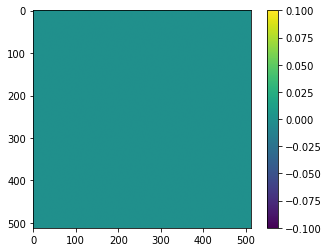

In [11]:
plt.imshow( np.abs( (np.int32(np.array(origin_img)) - np.int32(np.array(i_img))).mean(axis=-1)))
plt.colorbar()

In [12]:
i_delta_grid.max()

0.0

In [13]:
i_mapx

array([[  0.,   1.,   2., ..., 509., 510., 511.],
       [  0.,   1.,   2., ..., 509., 510., 511.],
       [  0.,   1.,   2., ..., 509., 510., 511.],
       ...,
       [  0.,   1.,   2., ..., 509., 510., 511.],
       [  0.,   1.,   2., ..., 509., 510., 511.],
       [  0.,   1.,   2., ..., 509., 510., 511.]], dtype=float32)

In [14]:
(i_grid[:, :, 0] * (512-1)).astype(np.float32)

array([[  0.,   1.,   2., ..., 509., 510., 511.],
       [  0.,   1.,   2., ..., 509., 510., 511.],
       [  0.,   1.,   2., ..., 509., 510., 511.],
       ...,
       [  0.,   1.,   2., ..., 509., 510., 511.],
       [  0.,   1.,   2., ..., 509., 510., 511.],
       [  0.,   1.,   2., ..., 509., 510., 511.]], dtype=float32)

In [15]:
(i_grid * 511)[...,0].astype(np.float32)

array([[  0.,   1.,   2., ..., 509., 510., 511.],
       [  0.,   1.,   2., ..., 509., 510., 511.],
       [  0.,   1.,   2., ..., 509., 510., 511.],
       ...,
       [  0.,   1.,   2., ..., 509., 510., 511.],
       [  0.,   1.,   2., ..., 509., 510., 511.],
       [  0.,   1.,   2., ..., 509., 510., 511.]], dtype=float32)

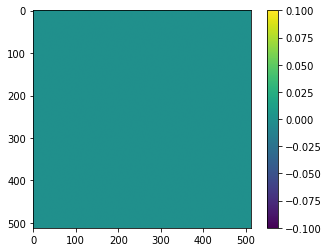

In [16]:
i_warped = cv2.remap(np.array(origin_img), (i_grid * 511)[...,0].astype(np.float32), (i_grid * 511)[...,1].astype(np.float32), cv2.INTER_CUBIC)
plt.imshow( np.abs( (np.int32(np.array(origin_img)) - np.int32(np.array(i_warped))).mean(axis=-1)))
plt.colorbar()

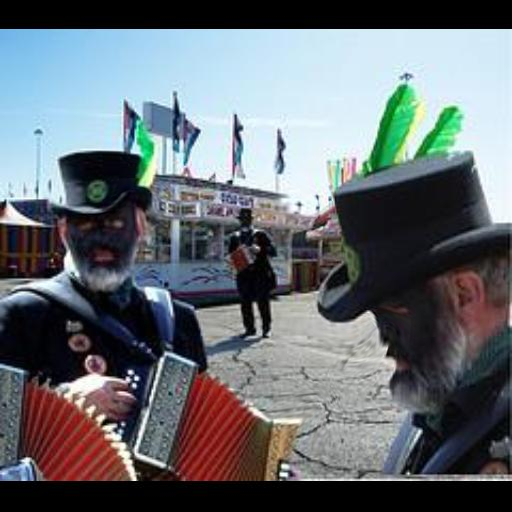

In [17]:
warpped_img

In [18]:
np.array(identity_warp)[100:101,100:101],np.array(identity_warp)[100:101,100:101].shape

(array([[[175, 221, 244]]], dtype=uint8), (1, 1, 3))

In [19]:
np.array(identity_warp)[100:101,100:101] - np.array(origin_img)[100:101,100:101]

array([[[0, 0, 0]]], dtype=uint8)

In [20]:
np.array(origin_img)[100:101,100:101], np.array(origin_img)[100:101,100:101].shape

(array([[[175, 221, 244]]], dtype=uint8), (1, 1, 3))

In [21]:
( np.int32(np.array(origin_img)) - np.int32(np.array(identity_warp)) ).mean()

0.0

In [22]:
mapx[100:101,100:101], mapy[100:101,100:101]

(array([[99.99738]], dtype=float32), array([[99.98966]], dtype=float32))

In [23]:
np.array(identity_warp,dtype=np.int32)[100:101,100:101] - np.array(origin_img,dtype=np.int32)[100:101,100:101]

array([[[0, 0, 0]]], dtype=int32)

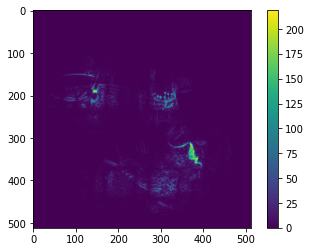

In [24]:
plt.imshow( np.abs( (np.int32(np.array(origin_img)) - np.int32(np.array(warpped_img))).mean(axis=-1)))
plt.colorbar()

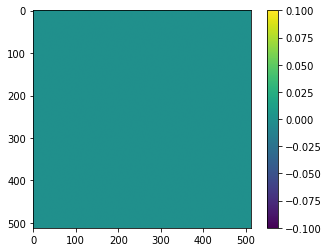

In [25]:
plt.imshow( np.abs( (np.int32(np.array(origin_img)) - np.int32(np.array(identity_warp))).mean(axis=-1)) )
plt.colorbar()


In [26]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex')
basic_transform = transforms.Compose(
[
        transforms.ToTensor(),
        transforms.Normalize((0., 0., 0.), (1., 1., 1.))
])

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/me/.local/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


In [27]:
warpped_tensor = basic_transform(warpped_img)
origin_tensor = basic_transform(origin_img)

In [28]:
def extract_to_patches(x,k_size):
    batch_size, n_channels, n_rows, n_cols = warpped_tensor.unsqueeze(0).shape
    kernel_h, kernel_w, step = k_size, k_size, k_size
    windows = x.unfold(2, kernel_h, step).unfold(3, kernel_w, step).permute(2, 3, 0, 1, 4, 5).reshape(-1, n_channels, kernel_h, kernel_w)
    return windows

In [29]:
wp = extract_to_patches(warpped_tensor.unsqueeze(0),k_size=image_size[0]//16)
op = extract_to_patches(origin_tensor.unsqueeze(0),k_size = image_size[0]//16)
wp = torchvision.transforms.functional.resize(wp,size=(64,64))
op = torchvision.transforms.functional.resize(op,size=(64,64))
print(wp.shape)
d = loss_fn_alex(wp, op)
print(d.mean())

torch.Size([256, 3, 64, 64])
tensor(0.0095, grad_fn=<MeanBackward0>)


torch.Size([3, 16, 16, 32, 32])


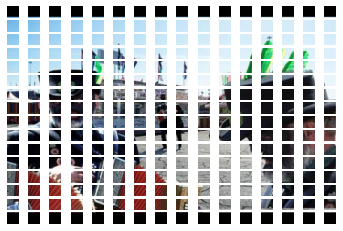

In [55]:
from torchvision.transforms.functional import to_pil_image
NUM_SIZE = 16
PATCH_SIZE = k_size=image_size[0]//NUM_SIZE
patches = warpped_tensor.unfold(1, PATCH_SIZE, PATCH_SIZE).unfold(2, PATCH_SIZE, PATCH_SIZE)
print(patches.shape)
fig, ax = plt.subplots(NUM_SIZE, NUM_SIZE)
for i in range(NUM_SIZE):
    for j in range(NUM_SIZE):
        sub_img = patches[:, i, j]
        ax[i][j].imshow(to_pil_image(sub_img))
        ax[i][j].axis('off')

In [57]:
mask = torch.from_numpy(np.linalg.norm(neighbor_warpped_delta_grid, axis=2)).unsqueeze(0)
min_max_norm_f = lambda x : (x - x.min()) / (x.max() - x.min())
mask = min_max_norm_f(mask)
mask[mask<0.2] = 0
from torchvision.transforms.functional import to_pil_image
NUM_SIZE = 16
PATCH_SIZE = k_size=image_size[0]//NUM_SIZE
patches = mask.unfold(1, PATCH_SIZE, PATCH_SIZE).unfold(2, PATCH_SIZE, PATCH_SIZE)
warpped_patches = warpped_tensor.unfold(1, PATCH_SIZE, PATCH_SIZE).unfold(2, PATCH_SIZE, PATCH_SIZE)
origin_patches = origin_tensor.unfold(1, PATCH_SIZE, PATCH_SIZE).unfold(2, PATCH_SIZE, PATCH_SIZE)
print(patches.shape)

have_mask_list = []
fig, ax = plt.subplots(NUM_SIZE, NUM_SIZE)
for i in range(NUM_SIZE):
    for j in range(NUM_SIZE):
        sub_img = patches[:, i, j]
        if(torch.count_nonzero(sub_img)!=0):
            have_mask_list.append((i,j))
        ax[i][j].imshow(to_pil_image(sub_img))
        ax[i][j].axis('off')

torch.Size([1, 16, 16, 32, 32])


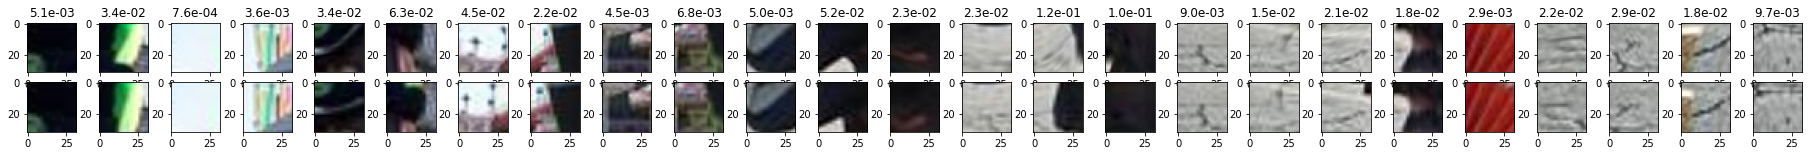

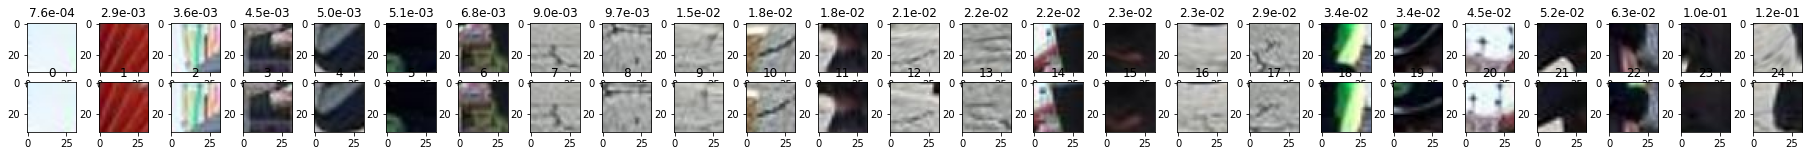

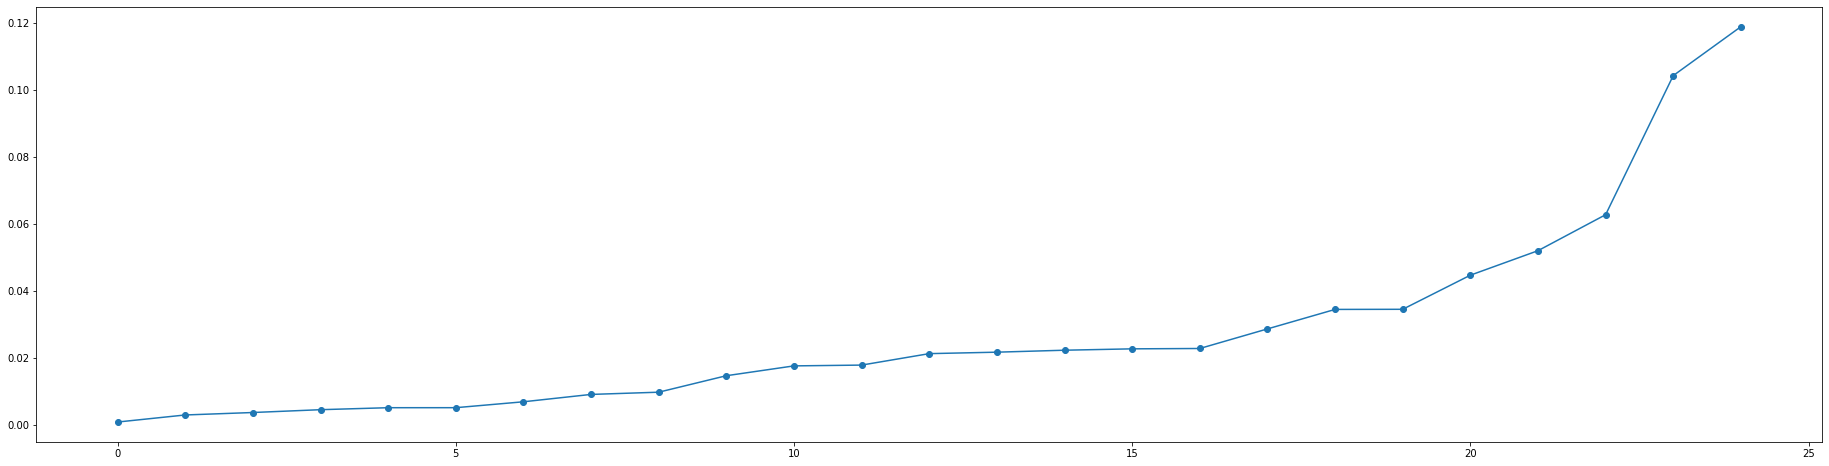

In [65]:
fig, ax = plt.subplots(2,len(have_mask_list), figsize=(32, 2))
loss_list = []
for idx,(i,j) in enumerate(have_mask_list):
    w_patch = warpped_patches[:,i,j]
    o_patch = origin_patches[:,i,j]
    loss = loss_fn_alex(w_patch,o_patch).mean().item()
    loss_list.append(loss)
    ax[0][idx].set_title(f'{loss:.1e}')
    ax[0][idx].imshow(to_pil_image(w_patch))
    ax[1][idx].imshow(to_pil_image(o_patch))
sort_loss_list_idx = sorted(range(len(loss_list)), key = lambda k : loss_list[k]) 
sort_have_mask_list = [ have_mask_list[i] for i in sort_loss_list_idx ]
fig, ax = plt.subplots(2,len(have_mask_list), figsize=(32, 2))
loss_list = []
for idx,(i,j) in enumerate(sort_have_mask_list):
    w_patch = warpped_patches[:,i,j]
    o_patch = origin_patches[:,i,j]
    loss = loss_fn_alex(w_patch,o_patch).mean().item()
    loss_list.append(loss)
    ax[0][idx].set_title(f'{loss:.1e}')
    ax[0][idx].imshow(to_pil_image(w_patch))
    ax[1][idx].set_title(f'{idx}')
    ax[1][idx].imshow(to_pil_image(o_patch))
plt.figure(figsize=(32,8))
plt.plot(sorted(loss_list),marker='o')
plt.show()

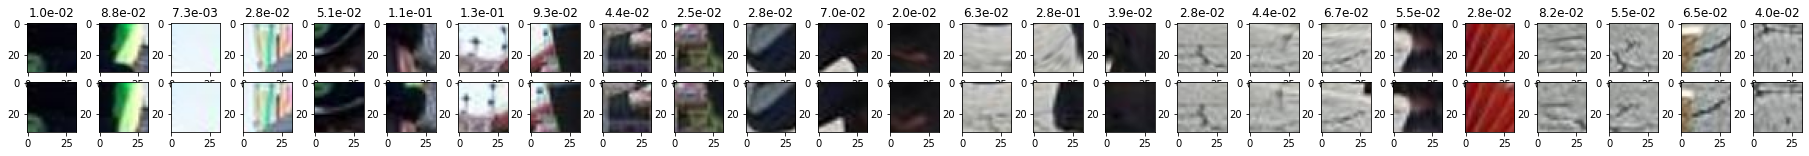

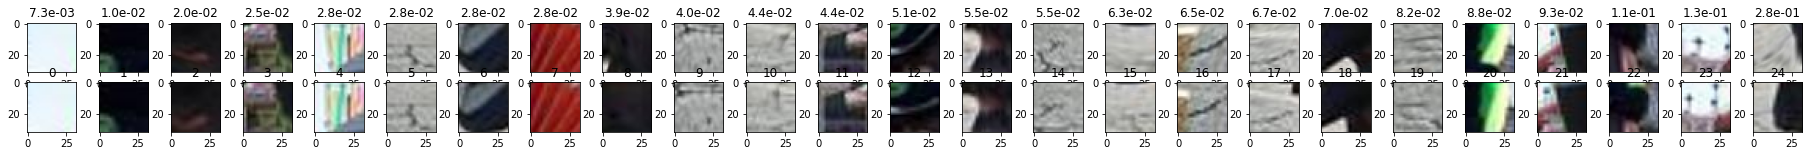

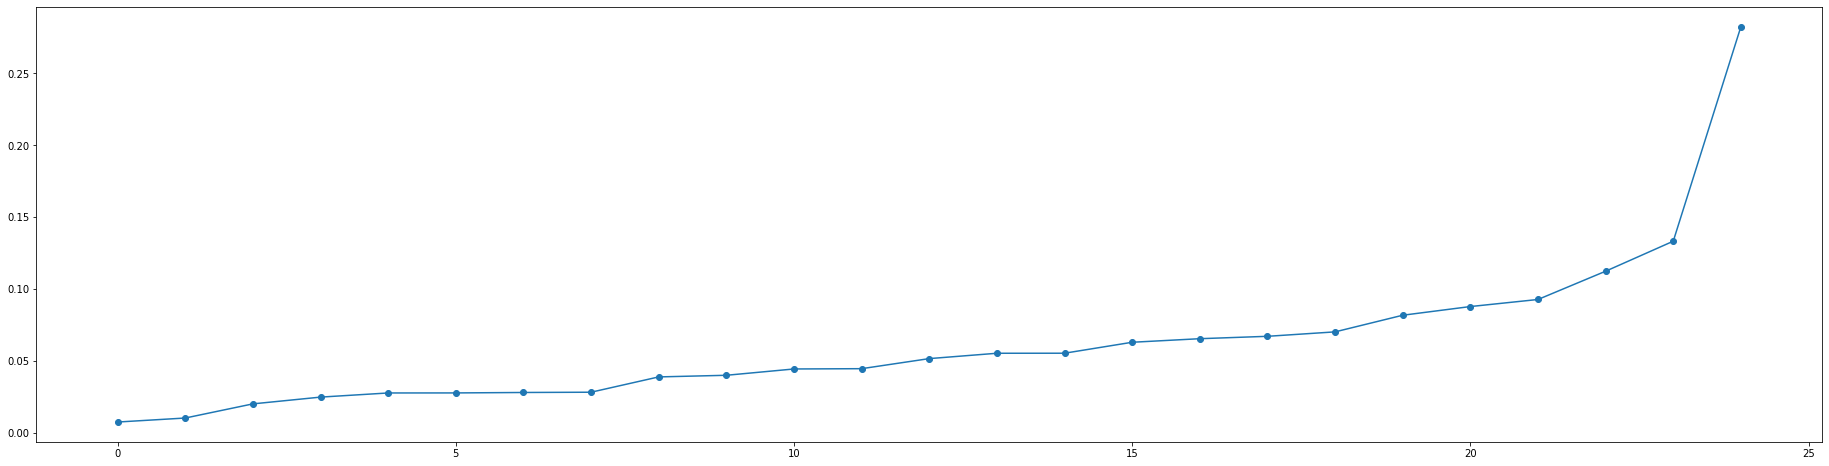

In [64]:
fig, ax = plt.subplots(2,len(have_mask_list), figsize=(32, 2))
l1_loss_list = []
for idx,(i,j) in enumerate(have_mask_list):
    w_patch = warpped_patches[:,i,j]
    o_patch = origin_patches[:,i,j]
    loss = torch.nn.functional.l1_loss(w_patch,o_patch)
    l1_loss_list.append(loss)
    ax[0][idx].set_title(f'{loss:.1e}')
    ax[0][idx].imshow(to_pil_image(w_patch))
    ax[1][idx].imshow(to_pil_image(o_patch))
    
sort_l1_loss_list_idx = sorted(range(len(l1_loss_list)), key = lambda k : l1_loss_list[k]) 
sort_l1_have_mask_list = [ have_mask_list[i] for i in sort_l1_loss_list_idx ]
fig, ax = plt.subplots(2,len(have_mask_list), figsize=(32, 2))
l1_loss_list = []
for idx,(i,j) in enumerate(sort_l1_have_mask_list):
    w_patch = warpped_patches[:,i,j]
    o_patch = origin_patches[:,i,j]
    loss = torch.nn.functional.l1_loss(w_patch,o_patch)
    l1_loss_list.append(loss)
    ax[0][idx].set_title(f'{loss:.1e}')
    ax[0][idx].imshow(to_pil_image(w_patch))
    ax[1][idx].set_title(f'{idx}')
    ax[1][idx].imshow(to_pil_image(o_patch))
plt.figure(figsize=(32,8))
plt.plot(sorted(l1_loss_list),marker='o')
plt.show()



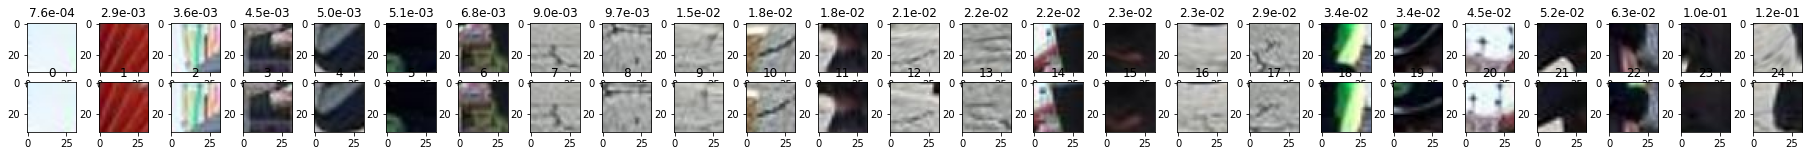

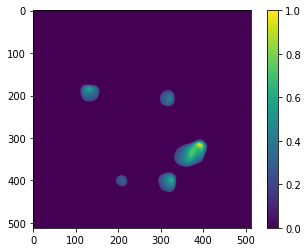

In [35]:
mask = torch.from_numpy(np.linalg.norm(neighbor_warpped_delta_grid, axis=2)).unsqueeze(0)
min_max_norm_f = lambda x : (x - x.min()) / (x.max() - x.min())
mask = min_max_norm_f(mask)
mask[mask<0.2] = 0
plt.imshow(mask[0], vmax=1, vmin=0)
plt.colorbar()

In [ ]:
diff_map = np.abs( (np.int32(np.array(origin_img)) - np.int32(np.array(warpped_img))).mean(axis=-1))/256
diff_map[diff_map < 0.1] = 0
diff_map[diff_map >= 0.1] = 1
plt.imshow(diff_map)
plt.colorbar()
diff_tensor = torch.from_numpy(diff_map).unsqueeze(0)
print(diff_tensor.shape)
from torchvision.transforms.functional import to_pil_image
NUM_SIZE = 16
PATCH_SIZE = k_size=image_size[0]//NUM_SIZE
patches = diff_tensor.unfold(1, PATCH_SIZE, PATCH_SIZE).unfold(2, PATCH_SIZE, PATCH_SIZE)
warpped_patches = warpped_tensor.unfold(1, PATCH_SIZE, PATCH_SIZE).unfold(2, PATCH_SIZE, PATCH_SIZE)
origin_patches = origin_tensor.unfold(1, PATCH_SIZE, PATCH_SIZE).unfold(2, PATCH_SIZE, PATCH_SIZE)
print(patches.shape)

have_diff_list = []
for i in range(NUM_SIZE):
    for j in range(NUM_SIZE):
        sub_img = patches[:, i, j]
        if(torch.count_nonzero(sub_img)!=0):
            have_diff_list.append((i,j))


In [ ]:
fig, ax = plt.subplots(2,len(have_mask_list), figsize=(32, 2))
diff_list = []
for idx,(i,j) in enumerate(have_mask_list):
    w_patch = warpped_patches[:,i,j]
    o_patch = origin_patches[:,i,j]
    loss = loss_fn_alex(w_patch,o_patch).mean().item()
    loss_list.append(loss)
    ax[0][idx].set_title(f'{loss:.1e}')
    ax[0][idx].imshow(to_pil_image(w_patch))
    ax[1][idx].imshow(to_pil_image(o_patch))


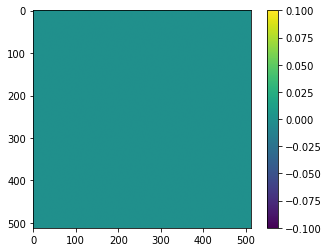

In [36]:
plt.imshow( np.abs( (np.int32(np.array(origin_img)) - np.int32(np.array(identity_warp))).mean(axis=-1)) )
plt.colorbar()


In [37]:
np.random.randint(3)

1

In [38]:
red_mask_f = lambda mask :  np.stack([ np.zeros_like(mask[...,0]),mask[...,0], np.zeros_like(mask[...,0])],axis=-1)

TypeError: unsupported operand type(s) for *: 'numpy.ndarray' and 'Tensor'

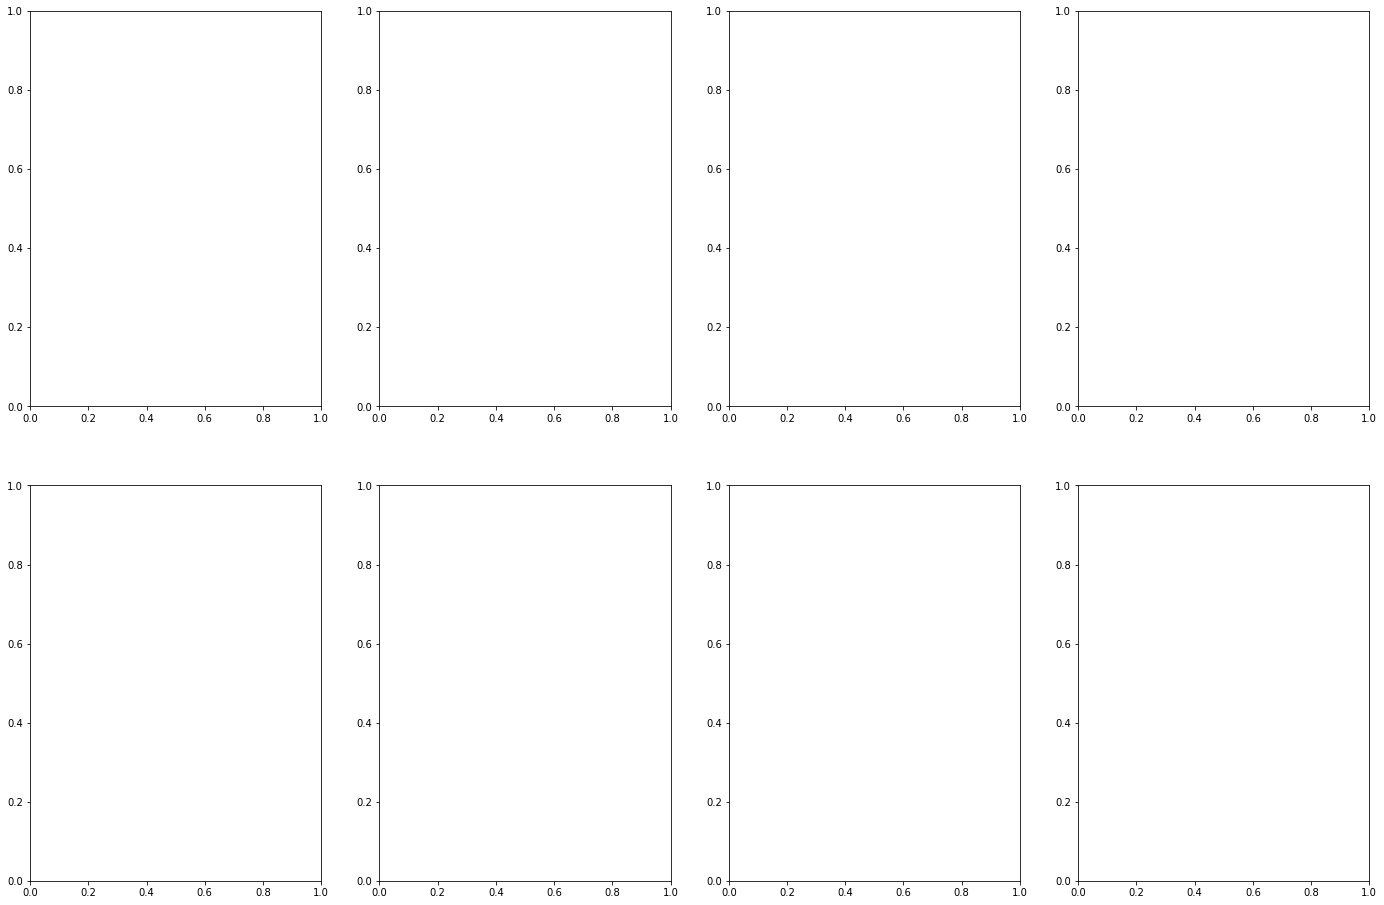

In [39]:
# mask_f = lambda x,mask : Image.fromarray(np.uint8(np.array(x) * (1-mask) ))
# min_max_norm_f = lambda x : (x - x.min()) / (x.max() - x.min())
# # mask = min_max_norm_f(np.linalg.norm(warpped_delta_grid, axis=2)[...,np.newaxis])
# # mask_n = min_max_norm_f(np.linalg.norm(neighbor_warpped_delta_grid, axis=2)[...,np.newaxis])

# # show_grid_img =grid_img
# # show_warpped_grid_img = cv2.remap(grid_img, mapx, mapy, cv2.INTER_CUBIC )
# fig, axs = plt.subplots(2, 4, figsize=(24,16))
# axs[0,0].imshow(mask_f(warpped_img, mask))
# # axs[1,0].imshow(mask_f(show_warpped_grid_img, mask))
# axs[0,1].imshow(mask_f(warpped_img, mask_n))
# # axs[1,1].imshow(mask_f(show_warpped_grid_img, mask_n))
# axs[0,2].imshow(origin_img)
# axs[1,2].imshow(grid_img)
# axs[0,3].imshow(warpped_img)
# axs[1,3].imshow(show_warpped_grid_img)

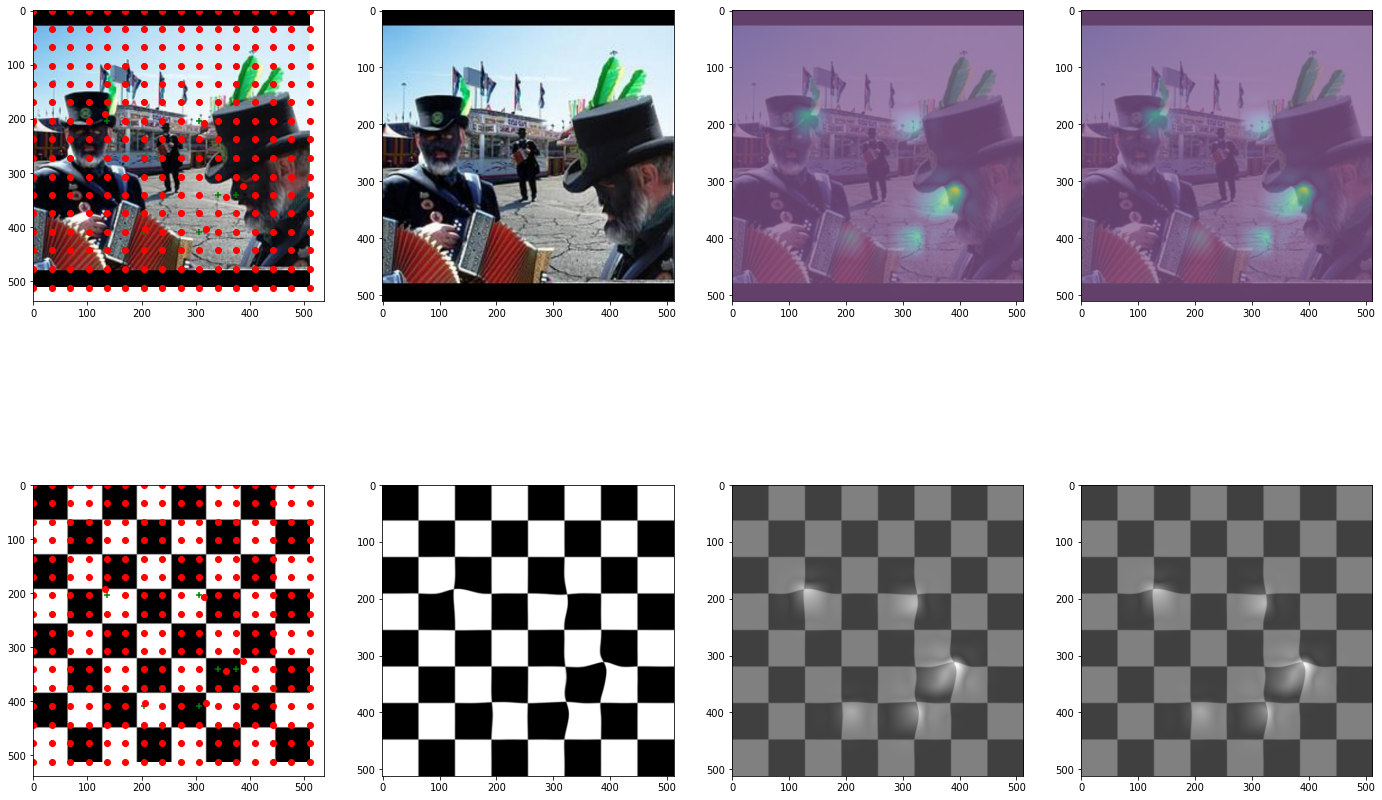

In [40]:
sshape,tshape = src_pts[np.newaxis,...] * img.shape[0] ,target_pts[np.newaxis,...] * img.shape[0]
# %matplotlib widget
show_img = origin_img
show_warpped_img = warpped_img
# show_identity_warp_img = identity_warp_img

show_grid_img =grid_img
show_warpped_grid_img = cv2.remap(grid_img, mapx, mapy, cv2.INTER_CUBIC )

# show_delta_grid = np.linalg.norm(delta_grid, axis=2)
show_warpped_delta_grid =  np.linalg.norm(warpped_delta_grid, axis=2)
show_neighbor_warpped_delta_grid =  np.linalg.norm(neighbor_warpped_delta_grid,axis=2)


linewidth = 0.8
fig, axs = plt.subplots(2, 4, figsize=(24,16))
axs[0,0].imshow(show_img)
axs[0,0].scatter(sshape[0,:,0],sshape[0,:,1], marker='+', color='green')
axs[0,0].scatter(tshape[0,:,0],tshape[0,:,1], marker='o', color='red')
# axs[0].plot(mesh[0], mesh[1], 'orange',linewidth= linewidth)
# axs[0].plot(mesh.T[..., 0], mesh.T[..., 1], 'orange',linewidth= linewidth)
axs[1,0].imshow(show_grid_img)
axs[1,0].scatter(sshape[0,:,0],sshape[0,:,1], marker='+', color='green')
axs[1,0].scatter(tshape[0,:,0],tshape[0,:,1], marker='o', color='red')

axs[0,1].imshow(show_warpped_img)
axs[1,1].imshow(show_warpped_grid_img)
# axs[1].imshow(np.array(origin_img) - np.array(warp_img))
# axs[1].plot(mesh_tran[0], mesh_tran[1], 'orange' ,linewidth= linewidth)
# axs[1].plot( mesh_tran.T[..., 0],mesh_tran.T[..., 1], 'orange' ,linewidth = linewidth)



# axs[2].imshow(np.ones_like(show_img) * 255)
axs[0,2].imshow(show_warpped_img, alpha =0.5)
# axs[2].imshow(np.linalg.norm(warpped_delta_grid, axis =2), alpha =0.5)
axs[0,2].imshow(show_warpped_delta_grid, alpha =0.5)

# axs[2].plot(mesh[0], mesh[1], 'blue', alpha=0.6)
# axs[2].plot(mesh.T[..., 0], mesh.T[..., 1], 'blue' , alpha=0.6)
# axs[2].plot(mesh_tran[0], mesh_tran[1], 'orange', alpha=0.6)
# axs[2].plot(mesh_tran.T[..., 0], mesh_tran.T[..., 1], 'orange', alpha=0.6)

# axs[0,2].scatter(sshape[0,:,0],sshape[0,:,1], marker='+', color='green')
# axs[0,2].scatter(tshape[0,:,0],tshape[0,:,1], marker='o', color='red')


axs[1,2].imshow(show_warpped_grid_img, alpha =0.5)
axs[1,2].imshow(show_warpped_delta_grid, alpha =0.5, cmap='gray')
# axs[1,2].scatter(sshape[0,:,0],sshape[0,:,1], marker='+', color='green')
# axs[1,2].scatter(tshape[0,:,0],tshape[0,:,1], marker='o', color='red')

axs[0,3].imshow(show_warpped_img, alpha =0.5)
axs[0,3].imshow(show_neighbor_warpped_delta_grid, alpha =0.5)
axs[1,3].imshow(show_warpped_grid_img, alpha =0.5)
axs[1,3].imshow(show_neighbor_warpped_delta_grid, alpha =0.5 , cmap='gray')


fig.show()


In [ ]:
plt.imshow(show_warpped_delta_grid)
plt.colorbar()
plt.show()
plt.imshow(show_neighbor_warpped_delta_grid)
plt.colorbar()
plt.show()

In [ ]:
# def get_neighbor_diff_guassian(input_tensor, kernel_size= 9, sigma = 1, channels = 2):

#     import math

#     # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
#     x_cord = torch.arange(kernel_size)
#     x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
#     y_grid = x_grid.t()
#     xy_grid = torch.stack([x_grid, y_grid], dim=-1)

#     mean = (kernel_size - 1)/2.
#     variance = sigma**2.

#     # Calculate the 2-dimensional gaussian kernel which is
#     # the product of two gaussian distributions for two different
#     # variables (in this case called x and y)
#     gaussian_kernel = (1./(2.*math.pi*variance)) *\
#                       torch.exp(
#                           -torch.sum((xy_grid - mean)**2., dim=-1) /\
#                           (2*variance)
#                       )
#     # Make sure sum of values in gaussian kernel equals 1.
#     gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)
#     # gaussian_kernel[kernel_size//2,kernel_size//2] =  0
#     gaussian_kernel *= -1
#     gaussian_kernel[kernel_size//2,kernel_size//2] =  gaussian_kernel.sum().abs()
    
#     # print(gaussian_kernel.shape)
    

#     # Reshape to 2d depthwise convolutional weight
#     gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
#     # print(gaussian_kernel)
    
#     padding = math.ceil((kernel_size - 1) /2)
#     # print(input_tensor.shape, input_tensor[:,0,:,:].unsqueeze(0).shape)
#     dx = torch.nn.functional.conv2d(input_tensor[:,0,:,:].unsqueeze(0), gaussian_kernel, bias=None,stride=1, padding =padding)
#     dy = torch.nn.functional.conv2d(input_tensor[:,1,:,:].unsqueeze(0), gaussian_kernel, bias=None,stride=1, padding =padding)
#     # print("dx",dx.shape)
#     result = torch.stack([dx[:,0,:,:], dy[:,0,:,:] ],dim=1)
#     # print(result.shape)
#     return result
#     # print(gaussian_kernel,gaussian_kernel.shape)
#     # return torch.nn.functional.conv2d(input_tensor, gaussian_kernel, bias=None,stride=1, padding =padding)
    
# def n_f(warpped_delta_grid,kernel_size):
#     warpped_delta_grid_tensor = torch.from_numpy(warpped_delta_grid).unsqueeze(0).permute(0,3,1,2).to(torch.float32)
#     neighbor_warpped_delta_grid = get_neighbor_diff_guassian(warpped_delta_grid_tensor, kernel_size= kernel_size).permute(0,2,3,1).float().numpy()
#     neighbor_warpped_delta_grid = neighbor_warpped_delta_grid[0]
#     return neighbor_warpped_delta_grid

# cond_list = [3,7,15,31,63,127]
# fig, axs = plt.subplots(1, len(cond_list)+1, figsize=(24,16))
# for i,k in enumerate(cond_list):
#     neighbor_warpped_delta_grid = n_f(warpped_delta_grid,k)
#     show_neighbor_warpped_delta_grid = min_max_norm_f(np.linalg.norm(neighbor_warpped_delta_grid, axis=2))
#     axs[i].set_title(f'k_size:{k}')
#     axs[i].imshow(show_neighbor_warpped_delta_grid )
# show_warpped_delta_grid = min_max_norm_f(np.linalg.norm(warpped_delta_grid, axis=2))
# axs[-1].set_title(f'no_k')
# axs[-1].imshow(show_warpped_delta_grid)

In [ ]:
# cond_list = [3,7,15]
# fig, axs = plt.subplots(1, len(cond_list)+1, figsize=(24,16))
# for i,k in enumerate(cond_list):
#     neighbor_warpped_delta_grid = n_f(warpped_delta_grid,k)
#     show_neighbor_warpped_delta_grid = min_max_norm_f(np.max(neighbor_warpped_delta_grid, axis=2))
#     axs[i].set_title(f'k_size:{k}')
#     axs[i].imshow(show_neighbor_warpped_delta_grid )
# show_warpped_delta_grid = min_max_norm_f(np.max(warpped_delta_grid, axis=2))
# axs[-1].set_title(f'no_k')
# axs[-1].imshow(show_warpped_delta_grid)
# plt.show()
# plt.imshow(show_neighbor_warpped_delta_grid)
# plt.colorbar()
# plt.show()

In [ ]:

# plt.imshow(warpped_delta_grid[...,0])
# plt.colorbar()
# plt.show()

# plt.imshow(neighbor_warpped_delta_grid[...,0])
# plt.colorbar()
# plt.show()


# # plt.imshow(np.linalg.norm(warpped_delta_grid, axis=2))
# # plt.colorbar()
# # plt.show()

# # plt.imshow(np.linalg.norm(neighbor_warpped_delta_grid, axis=2))
# # plt.colorbar()
# # plt.show()

In [ ]:
plt.imshow(np.array(warpped_img)[100:150,150:200])
plt.show()

warp_x = np.int32(warpped_delta_grid[...,0] * 255)
# plt.imshow(warp_x[100:150,150:200])
plt.imshow(warp_x)
plt.colorbar()
plt.show()

warp_y = np.int32(warpped_delta_grid[...,1] * 255)
# plt.imshow(warp_y[100:150,150:200])
plt.imshow(warp_y)
plt.colorbar()
plt.show()

print("----")
# plt.imshow(np.abs(warp_y))
# plt.colorbar()
# plt.show()


n_warp_x = np.int32(neighbor_warpped_delta_grid[...,0]*255)
plt.imshow(n_warp_x)
# plt.imshow(n_warp_x)
plt.colorbar()
plt.show()

n_warp_y = np.int32(neighbor_warpped_delta_grid[...,1]*255)
plt.imshow(n_warp_y)
# plt.imshow(n_warp_y)
plt.colorbar()
plt.show()

plt.imshow(show_warpped_delta_grid[100:150,150:200],vmin=0,vmax=1)
plt.colorbar()
plt.show()
plt.imshow(show_neighbor_warpped_delta_grid[100:150,150:200],vmin=0,vmax=1)
plt.colorbar()
plt.show()

In [ ]:
show_i_warpped_grid_img = cv2.remap(grid_img, mapx, mapx, cv2.INTER_CUBIC )
(show_i_warpped_grid_img - grid_img ).mean()

In [ ]:
mask = min_max_norm_f(show_warpped_delta_grid)[...,np.newaxis]
# threshold = 0.2
# mask[mask < threshold] = 0
# mask[mask >= threshold] = 1
plt.imshow(mask, vmin=0, vmax=1)
plt.colorbar()
plt.show()
masked_img = Image.fromarray(np.uint8(np.array(warpped_img) * (1-mask)))
plt.imshow(masked_img)
plt.show()
masked_oimg = Image.fromarray(np.uint8(np.array(origin_img) * (1-mask)))
plt.imshow(masked_oimg)
plt.show()
print((np.array(masked_img) - np.array(masked_oimg)).mean())

In [ ]:
mask = min_max_norm_f(show_neighbor_warpped_delta_grid)[...,np.newaxis]
# threshold = 0.2
# mask[mask < threshold] = 0
# mask[mask >= threshold] = 1
plt.imshow(mask, vmin=0, vmax=1)
plt.colorbar()
plt.show()
masked_img = Image.fromarray(np.uint8(np.array(warpped_img) * (1-mask)))
plt.imshow(masked_img)
plt.show()
masked_oimg = Image.fromarray(np.uint8(np.array(origin_img) * (1-mask)))
plt.imshow(masked_oimg)
plt.show()
print((np.array(masked_img) - np.array(masked_oimg)).mean())

In [ ]:
np.array(origin_img.convert('L')),np.array(identity_warp.convert('L'))
# plt.imshow(np.array(np.array(origin_img) - np.array(identity_warp)))

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(24,8))
axs[0].imshow(origin_img)
axs[1].imshow(identity_warp)
axs[2].imshow(warpped_img)
[( np.array(origin_img) - np.array(warpped_img) ).mean(), 
 ( np.array(identity_warp) - np.array(warpped_img) ).mean(), 
 ( np.array(origin_img) - np.array(identity_warp) ).mean()]

In [ ]:
sshape,tshape = src_pts[np.newaxis,...] * img.shape[0] ,target_pts[np.newaxis,...] * img.shape[0]
# %matplotlib widget
show_img = origin_img
show_warpped_img = warpped_img
# show_identity_warp_img = identity_warp_img

show_grid_img =grid_img
show_warpped_grid_img = cv2.remap(grid_img, mapx, mapy, cv2.INTER_CUBIC )

# show_delta_grid = np.linalg.norm(delta_grid, axis=2)
show_warpped_delta_grid = np.max(warpped_delta_grid, axis=2)
show_neighbor_warpped_delta_grid =  np.max(neighbor_warpped_delta_grid,axis=2)


linewidth = 0.8
fig, axs = plt.subplots(2, 4, figsize=(24,16))
axs[0,0].imshow(show_img)
axs[0,0].scatter(sshape[0,:,0],sshape[0,:,1], marker='+', color='green')
axs[0,0].scatter(tshape[0,:,0],tshape[0,:,1], marker='o', color='red')
# axs[0].plot(mesh[0], mesh[1], 'orange',linewidth= linewidth)
# axs[0].plot(mesh.T[..., 0], mesh.T[..., 1], 'orange',linewidth= linewidth)
axs[1,0].imshow(show_grid_img)
axs[1,0].scatter(sshape[0,:,0],sshape[0,:,1], marker='+', color='green')
axs[1,0].scatter(tshape[0,:,0],tshape[0,:,1], marker='o', color='red')

axs[0,1].imshow(show_warpped_img)
axs[1,1].imshow(show_warpped_grid_img)
# axs[1].imshow(np.array(origin_img) - np.array(warp_img))
# axs[1].plot(mesh_tran[0], mesh_tran[1], 'orange' ,linewidth= linewidth)
# axs[1].plot( mesh_tran.T[..., 0],mesh_tran.T[..., 1], 'orange' ,linewidth = linewidth)



# axs[2].imshow(np.ones_like(show_img) * 255)
axs[0,2].imshow(show_warpped_img, alpha =0.5)
# axs[2].imshow(np.linalg.norm(warpped_delta_grid, axis =2), alpha =0.5)
axs[0,2].imshow(show_warpped_delta_grid, alpha =0.5)

# axs[2].plot(mesh[0], mesh[1], 'blue', alpha=0.6)
# axs[2].plot(mesh.T[..., 0], mesh.T[..., 1], 'blue' , alpha=0.6)
# axs[2].plot(mesh_tran[0], mesh_tran[1], 'orange', alpha=0.6)
# axs[2].plot(mesh_tran.T[..., 0], mesh_tran.T[..., 1], 'orange', alpha=0.6)

# axs[0,2].scatter(sshape[0,:,0],sshape[0,:,1], marker='+', color='green')
# axs[0,2].scatter(tshape[0,:,0],tshape[0,:,1], marker='o', color='red')


axs[1,2].imshow(show_warpped_grid_img, alpha =0.5)
axs[1,2].imshow(show_warpped_delta_grid, alpha =0.5, cmap='Greys')
# axs[1,2].scatter(sshape[0,:,0],sshape[0,:,1], marker='+', color='green')
# axs[1,2].scatter(tshape[0,:,0],tshape[0,:,1], marker='o', color='red')

axs[0,3].imshow(show_warpped_img, alpha =0.5)
axs[0,3].imshow(show_neighbor_warpped_delta_grid, alpha =0.5)
axs[1,3].imshow(show_warpped_grid_img, alpha =0.5)
axs[1,3].imshow(show_neighbor_warpped_delta_grid, alpha =0.5 , cmap='Greys')


fig.show()


# ThinPlateSplineShape_v1

In [ ]:
import cv2
import numpy as np

In [ ]:
# ! pip install opencv-contrib-python-headless

In [ ]:
def display_cv(img):
    return display(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))

In [ ]:
# sshape = np.array([[100,100],[200,100],[240,200],[300,250]],np.float32)
# tshape = np.array([[100,180],[200,130],[240,220],[300,280]],np.float32)
# sshape = sshape.reshape(1,-1,2)
# tshape = tshape.reshape(1,-1,2)
# sshape.shape,tshape.shape

In [ ]:
# sshape = np.array([[0.1,0.1],[0.2,0.1],[0.7,0.2],[0.9,0.25]],np.float32)
# tshape = np.array([[0.1,0.18],[0.2,0.13],[0.7,0.22],[0.9,0.28]],np.float32)
# sshape = sshape.reshape(1,-1,2)
# sshape[...,0] *= img.shape[0]
# sshape[...,1] *= img.shape[1]
# tshape = tshape.reshape(1,-1,2)
# tshape[...,0] *= img.shape[0]
# tshape[...,1] *= img.shape[1]
# sshape.shape,tshape.shape

In [ ]:
sshape,tshape = src_pts[np.newaxis,...] * img.shape[0] ,target_pts[np.newaxis,...] * img.shape[0]

In [ ]:
sshape.shape

In [ ]:
matches = [cv2.DMatch(i,i,0) for i in range(len(src_pts)) ]

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

tps = cv2.createThinPlateSplineShapeTransformer()
tps.estimateTransformation(tshape,sshape,matches)
ret, tshape_ = tps.applyTransformation(sshape)
tps.estimateTransformation(tshape_,sshape,matches)
out_img_1 = tps.warpImage(img)


tps = cv2.createThinPlateSplineShapeTransformer()
tps.estimateTransformation(sshape,tshape,matches)
ret, tshape_ = tps.applyTransformation(sshape)
tps.estimateTransformation(sshape,tshape_,matches)
out_img_2 = tps.warpImage(img)

tps = cv2.createThinPlateSplineShapeTransformer()
tps.estimateTransformation(sshape,tshape,matches)
out_img_3 = tps.warpImage(img)

tps = cv2.createThinPlateSplineShapeTransformer()
tps.estimateTransformation(tshape,sshape,matches)
out_img_4 = tps.warpImage(img)

In [ ]:
ret

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
def show_warped(img, warped,sshape,tshape,tshape_):
    fig, axs = plt.subplots(1, 2, figsize=(16,8))
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].imshow(img, origin='upper')
    print(sshape[0].shape)
    axs[0].scatter(sshape[0,:,0],sshape[0,:,1], marker='+', color='red')
    axs[0].scatter(tshape[0,:,0],tshape[0,:,1], marker='o', color='green')
    axs[0].scatter(tshape_[0,:,0],tshape_[0,:,1], marker='x', color='blue')
    axs[1].imshow(warped, origin='upper')
    axs[1].scatter(sshape[0,:,0],sshape[0,:,1], marker='+', color='black')
    axs[1].scatter(tshape[0,:,0],tshape[0,:,1], marker='o', color='black')
    axs[1].scatter(tshape_[0,:,0],tshape[0,:,1], marker='x', color='black')
    # axs[1].scatter(tshape, marker='+', color='black')
    plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(24,8))
axs[0].imshow(show_img)
axs[1].imshow(show_warpped_img)
fig.show()


In [ ]:
show_warped(img,out_img_1,sshape,tshape,tshape_)

In [ ]:
show_warped(img,out_img_2,sshape,tshape,tshape_)

In [ ]:
show_warped(img,out_img_3,sshape,tshape,tshape_)

In [ ]:
show_warped(img,out_img_4,sshape,tshape,tshape_)